# ARIMA Model Notebook

In [4]:
# Import Packages
import numpy as np
import pmdarima as pm
import os
import gdown
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler , FunctionTransformer
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import plotly.express as px
import warnings

from sktime.forecasting.statsforecast import StatsForecastAutoARIMA as AutoARIMA
from sktime.transformations.series.detrend import ConditionalDeseasonalizer
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.base import ForecastingHorizon
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

In [6]:
os.environ['NIXTLA_ID_AS_COL'] = '1'

import seaborn as sns
sns.set_style("darkgrid") # Set the style to dark grid for better visibility

SEED = 8484

import pandas as pd
pd.options.display.max_columns = None


In [7]:
# Download data to the temporary folder
merged_data_file_id = '1o_EEumVnswul9MVsrdDwBch5rt7JTr0m'
merged_data_url = f'https://drive.google.com/uc?id={merged_data_file_id}'
merged_data_filepath = '../../temporary_files/merged.csv'
gdown.download(merged_data_url, merged_data_filepath, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1o_EEumVnswul9MVsrdDwBch5rt7JTr0m
To: c:\Users\Steven\Documents\Projects\ss24-capstone-team23-datallah-nkitts-steveso\temporary_files\merged.csv
100%|██████████| 438k/438k [00:00<00:00, 5.59MB/s]


'../../temporary_files/merged.csv'

## Load and Describe Data

In [8]:
data_df=pd.read_csv(merged_data_filepath)
data_df.head()

,City,Date,ZHVI,NewHomePermits,Population_In_Housing_Units,Owner_Occupied_Population,Renter-Occupied-Population,OOP_Moved_From_Different_County,OOP_Moved_From_Different_State,OOP_Moved_From_Abroad,ROP_Moved_From_Different_County,ROP_Moved_From_Different_State,ROP_Moved_From_Abroad,PropertyCrimeIncident,ViolentCrimeIncident,cargo_domestic_outbound,cargo_domestic_inbound,passenger_domestic_outbound,passenger_domestic_inbound,cargo_intl_outbound,cargo_intl_inbound,passenger_intl_outbound,passenger_intl_inbound,dem_senate_cnt,rep_senate_cnt,dem_house_cnt,rep_house_cnt,other_senate_cnt,other_house_cnt,dem_spons_legis_cnt,rep_spons_legis_cnt,other_spons_legis_cnt,dem_cospons_legis_cnt,rep_cospons_legis_cnt,other_cospons_legis_cnt,days_with_thunderstorms,precipitation,relative_humidity_avg,relative_humidity_min,relative_humidity_max,snowfall,temp_avg,temp_max,temp_min,CBRE_Open,CBRE_High,CBRE_Low,CBRE_Close,CBRE_Adj Close,CBRE_Volume,HOUS_Open,HOUS_High,HOUS_Low,HOUS_Close,HOUS_Adj Close,HOUS_Volume,EQR_Open,EQR_High,EQR_Low,EQR_Close,EQR_Adj Close,EQR_Volume,RMAX_Open,RMAX_High,RMAX_Low,RMAX_Close,RMAX_Adj Close,RMAX_Volume,RDFN_Open,RDFN_High,RDFN_Low,RDFN_Close,RDFN_Adj Close,RDFN_Volume,percentile,studio,1_bedroom,2_bedroom,3_bedroom,4_bedroom,tot_emp,a_mean,a_median,h_mean,h_median
0,Chicago,2010-01-01,201888.606600,345.0,9206524,6353379,2853145,63533,44473,12706,91300,97006,34237,14429.0,8335.0,17.0,14.0,168.0,164.0,17.0,16.0,74.0,72.0,2.0,1.0,12.0,4.0,0.0,0.0,10.0,3.0,0.0,125.0,14.0,0.0,1.0,1.13,77.0,66.0,87.0,9.1,21.9,27.4,16.4,13.81,14.38,12.17,12.3,12.3,65501500.0,0.0,0.0,0.0,0.0,0.0,0.0,34.06,34.53,31.4,32.05,16.86,58885600.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,41.25,765.730804,876.330580,994.059652,1218.447222,1372.496303,3542180,49140.0,36950.0,23.62,17.77
1,Dallas,2010-01-01,150742.550106,1565.0,6216118,4052381,2163737,81047,32419,12157,160116,75730,19473,5421.0,711.0,16.0,21.0,146.0,147.0,13.0,8.0,42.0,40.0,0.0,2.0,2.0,9.0,0.0,0.0,0.0,6.0,0.0,23.0,48.0,0.0,1.0,3.27,67.0,46.0,86.0,0.0,44.9,53.9,36.0,13.81,14.38,12.17,12.3,12.3,65501500.0,0.0,0.0,0.0,0.0,0.0,0.0,34.06,34.53,31.4,32.05,16.86,58885600.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.00,640.810744,703.833695,830.204024,1085.019817,1327.825169,2001860,46860.0,35280.0,22.53,16.96
2,Los Angeles,2010-01-01,418680.256759,433.0,12474432,6510008,5964424,52080,26040,26040,119288,89466,53679,8534.0,4444.0,38.0,39.0,138.0,138.0,20.0,20.0,78.0,78.0,2.0,0.0,16.0,9.0,0.0,0.0,5.0,0.0,0.0,133.0,24.0,0.0,0.0,4.94,57.0,36.0,77.0,0.0,60.2,69.4,50.9,13.81,14.38,12.17,12.3,12.3,65501500.0,0.0,0.0,0.0,0.0,0.0,0.0,34.06,34.53,31.4,32.05,16.86,58885600.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.00,999.314979,1183.694503,1460.828359,1988.891365,2365.863015,3817570,50240.0,36790.0,24.16,17.69
3,New York,2010-01-01,393767.004762,874.0,18324602,10196421,8128181,112160,61178,30589,203204,162563,121922,19472.0,9411.0,33.0,30.0,138.0,127.0,35.0,36.0,152.0,151.0,2.0,0.0,26.0,4.0,0.0,0.0,23.0,5.0,0.0,188.0,20.0,0.0,0.0,2.09,58.0,45.0,71.0,2.1,32.5,38.1,27.0,13.81,14.38,12.17,12.3,12.3,65501500.0,0.0,0.0,0.0,0.0,0.0,0.0,34.06,34.53,31.4,32.05,16.86,58885600.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.00,1079.002546,1200.045451,1371.690954,1714.454248,1913.721353,241590,46270.0,36100.0,22.25,17.36
4,Seattle,2010-01-01,333469.123267,1190.0,3340958,2150701,1190257,25808,19356,10753,57132,65464,26185,4600.0,794.0,13.0,13.0,108.0,109.0,7.0,6.0,23.0,26.0,2.0,0.0,4.0,1.0,0.0,0.0,2.0,1.0,0.0,31.0,6.0,0.0,0.0,6.18,76.0,62.0,91.0,0.0,47.0,51.4,42.5,13.81,14.38,12.17,12.3,12.3,65501500.0,0.0,0.0,0.0,0.0,0.0,0.0,34.06,34.53,31.4,32.05,16.86,58885600.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,45.00,745.725796,854.419345,1035.655905,1473.043003,1768.440837,1346300,54610.0,44090.0,26.25,21.20


In [161]:
#check for nulls
data_df.columns = data_df.columns.str.lower()
data_df.date=pd.to_datetime(data_df.date)
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 780 entries, 0 to 779
Data columns (total 85 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   city                             780 non-null    object        
 1   date                             780 non-null    datetime64[ns]
 2   zhvi                             780 non-null    float64       
 3   newhomepermits                   780 non-null    float64       
 4   population_in_housing_units      780 non-null    int64         
 5   owner_occupied_population        780 non-null    int64         
 6   renter-occupied-population       780 non-null    int64         
 7   oop_moved_from_different_county  780 non-null    int64         
 8   oop_moved_from_different_state   780 non-null    int64         
 9   oop_moved_from_abroad            780 non-null    int64         
 10  rop_moved_from_different_county  780 non-null    int64        

In [162]:
#seperate hud and zhvi data
data_h = data_df.drop(columns=['zhvi'], axis=1)
data_z = data_df.drop(columns=['studio', '1_bedroom', '2_bedroom', '3_bedroom', '4_bedroom', 'percentile'], axis=1)
display(data_h)
display(data_z)


,city,date,newhomepermits,population_in_housing_units,owner_occupied_population,renter-occupied-population,oop_moved_from_different_county,oop_moved_from_different_state,oop_moved_from_abroad,rop_moved_from_different_county,rop_moved_from_different_state,rop_moved_from_abroad,propertycrimeincident,violentcrimeincident,cargo_domestic_outbound,cargo_domestic_inbound,passenger_domestic_outbound,passenger_domestic_inbound,cargo_intl_outbound,cargo_intl_inbound,passenger_intl_outbound,passenger_intl_inbound,dem_senate_cnt,rep_senate_cnt,dem_house_cnt,rep_house_cnt,other_senate_cnt,other_house_cnt,dem_spons_legis_cnt,rep_spons_legis_cnt,other_spons_legis_cnt,dem_cospons_legis_cnt,rep_cospons_legis_cnt,other_cospons_legis_cnt,days_with_thunderstorms,precipitation,relative_humidity_avg,relative_humidity_min,relative_humidity_max,snowfall,temp_avg,temp_max,temp_min,cbre_open,cbre_high,cbre_low,cbre_close,cbre_adj close,cbre_volume,hous_open,hous_high,hous_low,hous_close,hous_adj close,hous_volume,eqr_open,eqr_high,eqr_low,eqr_close,eqr_adj close,eqr_volume,rmax_open,rmax_high,rmax_low,rmax_close,rmax_adj close,rmax_volume,rdfn_open,rdfn_high,rdfn_low,rdfn_close,rdfn_adj close,rdfn_volume,percentile,studio,1_bedroom,2_bedroom,3_bedroom,4_bedroom,tot_emp,a_mean,a_median,h_mean,h_median
0,Chicago,2010-01-01,345.0,9206524,6353379,2853145,63533,44473,12706,91300,97006,34237,14429.0,8335.0,17.0,14.0,168.0,164.0,17.0,16.0,74.0,72.0,2.0,1.0,12.0,4.0,0.0,0.0,10.0,3.0,0.0,125.0,14.0,0.0,1.0,1.13,77.0,66.0,87.0,9.1,21.9,27.4,16.4,13.81,14.38,12.17,12.30,12.30,65501500.0,0.00,0.00,0.00,0.00,0.00,0.0,34.06,34.53,31.40,32.05,16.86,58885600.0,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.0,41.25,765.730804,876.330580,994.059652,1218.447222,1372.496303,3542180,49140.0,36950.0,23.62,17.77
1,Dallas,2010-01-01,1565.0,6216118,4052381,2163737,81047,32419,12157,160116,75730,19473,5421.0,711.0,16.0,21.0,146.0,147.0,13.0,8.0,42.0,40.0,0.0,2.0,2.0,9.0,0.0,0.0,0.0,6.0,0.0,23.0,48.0,0.0,1.0,3.27,67.0,46.0,86.0,0.0,44.9,53.9,36.0,13.81,14.38,12.17,12.30,12.30,65501500.0,0.00,0.00,0.00,0.00,0.00,0.0,34.06,34.53,31.40,32.05,16.86,58885600.0,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.0,40.00,640.810744,703.833695,830.204024,1085.019817,1327.825169,2001860,46860.0,35280.0,22.53,16.96
2,Los Angeles,2010-01-01,433.0,12474432,6510008,5964424,52080,26040,26040,119288,89466,53679,8534.0,4444.0,38.0,39.0,138.0,138.0,20.0,20.0,78.0,78.0,2.0,0.0,16.0,9.0,0.0,0.0,5.0,0.0,0.0,133.0,24.0,0.0,0.0,4.94,57.0,36.0,77.0,0.0,60.2,69.4,50.9,13.81,14.38,12.17,12.30,12.30,65501500.0,0.00,0.00,0.00,0.00,0.00,0.0,34.06,34.53,31.40,32.05,16.86,58885600.0,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.0,40.00,999.314979,1183.694503,1460.828359,1988.891365,2365.863015,3817570,50240.0,36790.0,24.16,17.69
3,New York,2010-01-01,874.0,18324602,10196421,8128181,112160,61178,30589,203204,162563,121922,19472.0,9411.0,33.0,30.0,138.0,127.0,35.0,36.0,152.0,151.0,2.0,0.0,26.0,4.0,0.0,0.0,23.0,5.0,0.0,188.0,20.0,0.0,0.0,2.09,58.0,45.0,71.0,2.1,32.5,38.1,27.0,13.81,14.38,12.17,12.30,12.30,65501500.0,0.00,0.00,0.00,0.00,0.00,0.0,34.06,34.53,31.40,32.05,16.86,58885600.0,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.0,40.00,1079.002546,1200.045451,1371.690954,1714.454248,1913.721353,241590,46270.0,36100.0,22.25,17.36
4,Seattle,2010-01-01,1190.0,3340958,2150701,1190257,25808,19356,10753,57132,65464,26185,4600.0,794.0,13.0,13.0,108.0,109.0,7.0,6.0,23.0,26.0,2.0,0.0,4.0,1.0,0.0,0.0,2.0,1.0,0.0,31.0,6.0,0.0,0.0,6.18,76.0,62.0,91.0,0.0,47.0,51.4,42.5,13.81,14.38,12.17,12.30,12.30,65501500.0,0.00,0.00,0.00,0.00,0.00,0.0,34.06,34.53,31.40,32.05,16.86,58885600.0,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.0,45.00,745.725796,854.419345,1035.655905,1473.043003,1768.440837,1346300,54610.0,44090.0,26.25,21.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

,city,date,zhvi,newhomepermits,population_in_housing_units,owner_occupied_population,renter-occupied-population,oop_moved_from_different_county,oop_moved_from_different_state,oop_moved_from_abroad,rop_moved_from_different_county,rop_moved_from_different_state,rop_moved_from_abroad,propertycrimeincident,violentcrimeincident,cargo_domestic_outbound,cargo_domestic_inbound,passenger_domestic_outbound,passenger_domestic_inbound,cargo_intl_outbound,cargo_intl_inbound,passenger_intl_outbound,passenger_intl_inbound,dem_senate_cnt,rep_senate_cnt,dem_house_cnt,rep_house_cnt,other_senate_cnt,other_house_cnt,dem_spons_legis_cnt,rep_spons_legis_cnt,other_spons_legis_cnt,dem_cospons_legis_cnt,rep_cospons_legis_cnt,other_cospons_legis_cnt,days_with_thunderstorms,precipitation,relative_humidity_avg,relative_humidity_min,relative_humidity_max,snowfall,temp_avg,temp_max,temp_min,cbre_open,cbre_high,cbre_low,cbre_close,cbre_adj close,cbre_volume,hous_open,hous_high,hous_low,hous_close,hous_adj close,hous_volume,eqr_open,eqr_high,eqr_low,eqr_close,eqr_adj close,eqr_volume,rmax_open,rmax_high,rmax_low,rmax_close,rmax_adj close,rmax_volume,rdfn_open,rdfn_high,rdfn_low,rdfn_close,rdfn_adj close,rdfn_volume,tot_emp,a_mean,a_median,h_mean,h_median
0,Chicago,2010-01-01,201888.606600,345.0,9206524,6353379,2853145,63533,44473,12706,91300,97006,34237,14429.0,8335.0,17.0,14.0,168.0,164.0,17.0,16.0,74.0,72.0,2.0,1.0,12.0,4.0,0.0,0.0,10.0,3.0,0.0,125.0,14.0,0.0,1.0,1.13,77.0,66.0,87.0,9.1,21.9,27.4,16.4,13.81,14.38,12.17,12.30,12.30,65501500.0,0.00,0.00,0.00,0.00,0.00,0.0,34.06,34.53,31.40,32.05,16.86,58885600.0,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.0,3542180,49140.0,36950.0,23.62,17.77
1,Dallas,2010-01-01,150742.550106,1565.0,6216118,4052381,2163737,81047,32419,12157,160116,75730,19473,5421.0,711.0,16.0,21.0,146.0,147.0,13.0,8.0,42.0,40.0,0.0,2.0,2.0,9.0,0.0,0.0,0.0,6.0,0.0,23.0,48.0,0.0,1.0,3.27,67.0,46.0,86.0,0.0,44.9,53.9,36.0,13.81,14.38,12.17,12.30,12.30,65501500.0,0.00,0.00,0.00,0.00,0.00,0.0,34.06,34.53,31.40,32.05,16.86,58885600.0,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.0,2001860,46860.0,35280.0,22.53,16.96
2,Los Angeles,2010-01-01,418680.256759,433.0,12474432,6510008,5964424,52080,26040,26040,119288,89466,53679,8534.0,4444.0,38.0,39.0,138.0,138.0,20.0,20.0,78.0,78.0,2.0,0.0,16.0,9.0,0.0,0.0,5.0,0.0,0.0,133.0,24.0,0.0,0.0,4.94,57.0,36.0,77.0,0.0,60.2,69.4,50.9,13.81,14.38,12.17,12.30,12.30,65501500.0,0.00,0.00,0.00,0.00,0.00,0.0,34.06,34.53,31.40,32.05,16.86,58885600.0,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.0,3817570,50240.0,36790.0,24.16,17.69
3,New York,2010-01-01,393767.004762,874.0,18324602,10196421,8128181,112160,61178,30589,203204,162563,121922,19472.0,9411.0,33.0,30.0,138.0,127.0,35.0,36.0,152.0,151.0,2.0,0.0,26.0,4.0,0.0,0.0,23.0,5.0,0.0,188.0,20.0,0.0,0.0,2.09,58.0,45.0,71.0,2.1,32.5,38.1,27.0,13.81,14.38,12.17,12.30,12.30,65501500.0,0.00,0.00,0.00,0.00,0.00,0.0,34.06,34.53,31.40,32.05,16.86,58885600.0,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.0,241590,46270.0,36100.0,22.25,17.36
4,Seattle,2010-01-01,333469.123267,1190.0,3340958,2150701,1190257,25808,19356,10753,57132,65464,26185,4600.0,794.0,13.0,13.0,108.0,109.0,7.0,6.0,23.0,26.0,2.0,0.0,4.0,1.0,0.0,0.0,2.0,1.0,0.0,31.0,6.0,0.0,0.0,6.18,76.0,62.0,91.0,0.0,47.0,51.4,42.5,13.81,14.38,12.17,12.30,12.30,65501500.0,0.00,0.00,0.00,0.00,0.00,0.0,34.06,34.53,31.40,32.05,16.86,58885600.0,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.0,1346300,54610.0,44090.0,26.25,21.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
775,Chicago,2022-12-01,296163.399450,1530.0,9201710,6494770,2706940,110411,51958,19484,75794,102863,40604,11955.0,6369.0,24.0,33.0,180.0,179.0,30.0

In [163]:
data_z.describe()['zhvi']

,zhvi
count,780.000000
mean,381297.133937
min,142128.033534
25%,233608.993775
50%,374617.412607
75%,497278.792505
max,932703.062292
std,177879.634508


## Functions

In [195]:
def quick_plot(df,y, title="", marker='o', color='blue'):
  #like the function says quickplot timeseries
  plt.figure(figsize=(12, 6))
  sns.lineplot(data=df, x=df['date'], y=y, marker=marker, color=color)
  plt.title(f'{title}')
  plt.xlabel('Date')
  plt.ylabel(y)
  plt.grid(True)
  plt.show()


def ADF_stationarity_test(df, y):
  # Perform the Augmented Dickey-Fuller (ADF) test to assess stationarity
  result = adfuller(df[f'{y}'])

  print(f"ADF Statistic: {result[0]:.4f}")
  print(f"p-value: {result[1]:.4f}")
  print(f"Critical Values: {result[4]}")

  # Check the p-value against the significance level (0.05) to make a stationarity inference
  if result[1] <= 0.05:
      print("Reject the null hypothesis. Data has no unit root, indicating seasonality. stationary")
  else:
      print("Fail to reject the null hypothesis. Data has a unit root, indicating non-seasonality. not stationary")

def plot_decomp(df,y,title='',color='green'):
  decomposition = seasonal_decompose(df[f'{y}'], model='additive', period=12)
  fig, axes = plt.subplots(4, 1, figsize=(12, 8), sharex=True)

  # Plot the compomets
  decomposition.observed.plot(ax=axes[0], color=color)
  axes[0].set_ylabel('Observed')
  decomposition.trend.plot(ax=axes[1], color=color)
  axes[1].set_ylabel('Trend')
  decomposition.seasonal.plot(ax=axes[2], color=color)
  axes[2].set_ylabel('Seasonal')
  decomposition.resid.plot(ax=axes[3], color=color)
  axes[3].set_ylabel('Residual')
  plt.xlabel('Date (Months Index)')

  # Adjust subplot spacing and position the main title
  plt.suptitle(f'{title}', fontsize=16)
  plt.tight_layout()
  plt.subplots_adjust(top=0.9)
  plt.show()

def diff_corr_plots(df,y, num_diff=3, corr_xlim=25):
  df=df.copy()
  plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})
  # Original Series
  fig, axes = plt.subplots(num_diff+1, 2)
  axes[0, 0].plot(df[y]); axes[0, 0].set_title(f'Original Series {y}')
  plot_acf(df[y], ax=axes[0, 1])
  axes[0,1].set_xlim([0, corr_xlim])

  for i in range(num_diff):
    print(i)
    df[y] = df[y].diff()
    axes[i+1, 0].plot(df[y]); axes[i+1, 0].set_title(f'Level {i+1} Differencing')
    plot_acf(df[y].dropna(), ax=axes[i+1, 1])

  for ax in axes[:, 0]:
    ax.sharex(axes[0, 0])
  for ax in axes[:, 1]:
    ax.sharex(axes[0, 1])

  plt.subplots_adjust(left=0.1, right=0.95, top=0.95, bottom=0.1, wspace=0.2, hspace=0.6)


  return plt.show()



def arima_fit_plot(df,x, y, yaxis_label = "Values", title= "Actual vs. Forecasted", colors=['orange', 'blue'], add_text="" ):
  plt.figure(figsize=(12, 6))
  plt.title(f'{title}{add_text}', fontsize=16)
  plt.xlabel(f'{x}')
  plt.ylabel(f'{yaxis_label}')
  sns.lineplot(label='Actual', color=f'{colors[1]}', data=df, x=df[f'{x}'], y=df[y], )
  sns.lineplot(label='Forecasted', color=f'{colors[0]}', data=df, x=df[f'{x}'], y=df['prediction'], linestyle='--'  )

  plt.fill_between(df[f'{x}'], df['lower'], df['upper'], color='grey', alpha=0.3, label='Confidence Interval')

  y_range = max(df['prediction']) - min(df['prediction'])

  plt.axis([  # set scale
      min(df[f'{x}']), #x lower bound
      max(df[f'{x}']), #x upper bound
      min(df['prediction']) - 0.10 * y_range,  #y lower bound
      max(df['prediction']) + 0.10 * y_range   #y upper bound
  ])
  plt.legend()
  plt.show()

def arima_accuracy_metrics(df, y,  **kwargs):
  """
  Takes a DataFrame with observed series values and arima predicted values and returns
  metrics

  df = DataFrame expecting column names prediction and y  **kwargs = metric specification. if not specified default rmse
    supports rmse, smape, gmrae

  prints evaluation results
  returns metrics dictionary containing metric name as key and evaluation as value

  """
  do_smape = kwargs.get('smape', False)
  do_gmrae = kwargs.get('gmrae', False)
  do_rmse  = kwargs.get('rmse', False)
  do_mse = kwargs.get('mse', True)

  metrics={}
  if do_smape:
    smape = np.mean((np.abs(df['prediction'] - df[y]) /((np.abs(df['prediction'] +np.abs(df[y])) / 2))) * 100)
    metrics['smape'] = smape
    print(f"Symmetric Mean Absolute Percentage Error (SMAPE): {smape:.4f}")
    print(f'SMAPE of {smape:.4f} suggests that, on average, our forecasts deviate by about {smape:.4f}% from the actual values in a symmetric manner.\n')

  if do_gmrae:
    gmrae =np.prod(np.abs((df['prediction'] - df[y])/ df['prediction']) ** (1/len(df["prediction"])))*100
    metrics['gmrae'] = gmrae
    print(f"Geometric Mean Relative Absolute Error (GMRAE): {gmrae:.4f}")
    print(f'A GMRAE value of {gmrae:.4f} indicates that, on average, the forecasted values have an error of approximately {gmrae:.4f}% relative to the actual values.\n')

  if do_rmse:
    rmse = mean_squared_error(df['prediction'], df[y], squared=False)
    metrics['rmse'] = rmse
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f'RMSE of {rmse:.4f} suggests that, on average, the forecasts are off by about {rmse:.4f} dollars from the actual values.\n')

  if do_mse:
    mse = mean_squared_error(df['prediction'], df[y], squared=True)
    rmse = mean_squared_error(df['prediction'], df[y], squared=False)
    metrics['mse'] = mse
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f'MSE of {mse:.4f} suggests that, on average, the forecasts are off by about {rmse:.4f} dollars from the actual values.\n')


  return metrics

def auto_arima_model(df, y, X=pd.DataFrame(), split_percent =0.9, show=True, **kwargs):
  warnings.filterwarnings("ignore")

  columns=['date']+[ f'{y}']
  if not X.empty:
    x_columns=X.columns.to_list()
    columns=columns + x_columns

  input_df = df[columns]
  train_size = int(len(input_df) * split_percent)
  train_data = input_df.iloc[:train_size]
  test_data = input_df.iloc[train_size:]

  X_train = None
  X_test  = None
  y_train = train_data[f'{y}']
  y_test  = test_data[f'{y}']
  if not X.empty:
    X_train = train_data.drop(columns=[f'{y}','date'])
    X_test = test_data.drop(columns=[f'{y}', 'date'])

  forecast = AutoARIMA( n_jobs=-1, **kwargs)
  fh_train = ForecastingHorizon(train_data.index, is_relative=False)
  fh_test = ForecastingHorizon(test_data.index, is_relative=False)
  model=forecast.fit(y=train_data[f'{y}'], X=X_train, fh=fh_train)

  future_prediction = model.predict(fh=fh_test,X=X_test)
  past_prediction=model.predict(fh=fh_train, X=X_train)
  conf_interval = model.predict_interval(fh=fh_test, X=X_test, coverage=.95)
  conf_interval.columns = ['_'.join(map(str, col)).strip() for col in conf_interval.columns.values]
  conf_interval.columns = [col.split('_')[-1] for col in conf_interval.columns.values]

  params = forecast.get_fitted_params()
  model_params=params['model']['arma']
  param_dict ={
      'p': model_params[0] ,
      'd': model_params[5] ,
      'q': model_params[1] ,
      'P': model_params[2] ,
      'D': model_params[6] ,
      'Q': model_params[3] ,
      'sp': model_params[4]
  }

  #rebuild dataframe for final table
  train_data = train_data.merge(past_prediction.to_frame(name='prediction'),left_index=True, right_index=True)
  train_data['lower'] = None
  train_data['upper'] = None
  test_data= test_data.merge(future_prediction.to_frame(name='prediction'),left_index=True, right_index=True)
  test_data= test_data.join(conf_interval, how='outer')
  final_data=pd.concat([train_data,test_data])

  if show:
    display(final_data)
    print(f'AIC = {params["model"]["aicc"]:.0f}')
    print(f'BIC = {params["model"]["bic"]:.0f}')
    param_str=''
    for key in param_dict:
      print(f'{key} = {param_dict[key]}')


  return final_data, param_dict

def diagnostic_plot(forecast_df, forecast_params_dict, title="Diagnostic Plots", add_text="" ):
  plt.close('all')
  if len(forecast_df.columns)>5:
    exog=forecast_df.copy().drop(columns=['date',	f'{to_predict}', 'zhvi',	'prediction',	'lower',	'upper'])
  else:
    exog = None

  if forecast_params_dict['sp']>1:
    model = ARIMA(df[f'{to_predict}'],
                  order=(forecast_params_dict['p'],forecast_params_dict['d'],forecast_params_dict['q']),
                  seasonal_order=(forecast_params_dict['P'],forecast_params_dict['D'],forecast_params_dict['Q'],forecast_params_dict['sp']),
                  exog=exog)
  else:

    model = ARIMA(df[f'{to_predict}'],
                  order=(forecast_params_dict['p'],forecast_params_dict['d'],forecast_params_dict['q']),
                  exog=exog)

  res=model.fit()

  fig = res.plot_diagnostics(figsize=(10, 8))
  fig.tight_layout(pad=2.0, h_pad=2)
  fig.subplots_adjust(top=0.9)
  fig.suptitle(f"{title}: {add_text}", fontsize=16, y=1.05)


  return  plt.show()

def explained_var_plot(pca, explained_percent=0.95):
  cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
  fig, ax1 = plt.subplots(figsize=(10, 6))

  ax1.plot(cumulative_variance, color='black', marker='o', linestyle='-', linewidth=1, label='Cumulative Explained Variance')
  ax1.set_xlabel('Number of Components')
  ax1.set_ylabel('Percentage Explained Variance')
  ax1.set_ylim(0, 1)

  ax1.grid(True)

  # Horizontal red line at explained variance = 0.9
  ax1.axhline(y=explained_percent, color='red', linestyle='--', linewidth=1)
  # Find the number of components needed to reach 0.9 cumulative variance
  num_components = np.argmax(cumulative_variance >= explained_percent)
  # Vertical red line at the number of components needed to reach 0.9 variance
  ax1.axvline(x=num_components, color='red', linestyle='--', linewidth=1)

  ax1.set_title(f'Cumulative Explained Variance\n{num_components} Principal Componets explain [{pipe.get_params()["pca__n_components"]*100}%] of the variance.')

  # Create a secondary y-axis
  ax2 = ax1.twinx()
  # The heights of the bars will be the explained variance for each component
  explained_variance = pca.explained_variance_ratio_

  # Plot feature importance as bars
  ax2.bar(range(len(explained_variance)), explained_variance, alpha=0.6, color='blue', label='Individual Explained Variance')
  #ax2.set_ylabel('Individual Explained Variance')
  ax2.set_ylim(0, 1)
  ax2.set_yticks([])

  # Add legends
  ax1.legend(loc='upper left')
  ax2.legend(loc='upper right')

  plt.show()
  return





In [165]:
class XyCitySelectScale(BaseEstimator, TransformerMixin):
  def __init__(self, city, target_column, scaler=StandardScaler):
    self.city = city
    self.target_column = target_column
    self.scaler = scaler()
    self.scaler_fitted = None

  def fit(self, X, y=None):
    X=X[X['city'] == self.city].drop('city', axis=1)
    if self.scaler is not None:
      self.scaler_fitted = self.scaler.fit(X)
      self.target_column_index = list(X.columns).index(self.target_column)
    return self

  def transform(self, X, y=None):
    X=X[X['city'] == self.city].drop('city', axis=1)
    self.index_ = X.index
    columns = X.columns


    if self.scaler is not None:
      X = self.scaler.transform(X)
      X = pd.DataFrame(X, columns=columns, index=self.index_)
      self.y_= X[self.target_column].values
      X = X.drop(columns=[self.target_column])
      return X.values

    self.y_ = X[self.target_column].values
    X=X.drop(columns=[self.target_column]).values

    return X

  def get_target(self):
    return self.y_

  def get_index(self):
    return self.index_

  def inverse_transform_y(self,y, feature_name):
    if self.scaler_fitted is not None:
      feature_index = list(self.scaler_fitted.feature_names_in_).index(feature_name)
      feature_scale = self.scaler_fitted.scale_[feature_index]
      feature_mean = self.scaler_fitted.mean_[feature_index]
      y_original = (y * feature_scale) + feature_mean
      return y_original
    return  y

## Visualize the Data

In [166]:
#initialize view
for city in list(data_df['city'].unique()):
  print(city)

city = 'Chicago'
df = data_df[data_df['city']==city].reset_index(drop=True)

Chicago
Dallas
Los Angeles
New York
Seattle


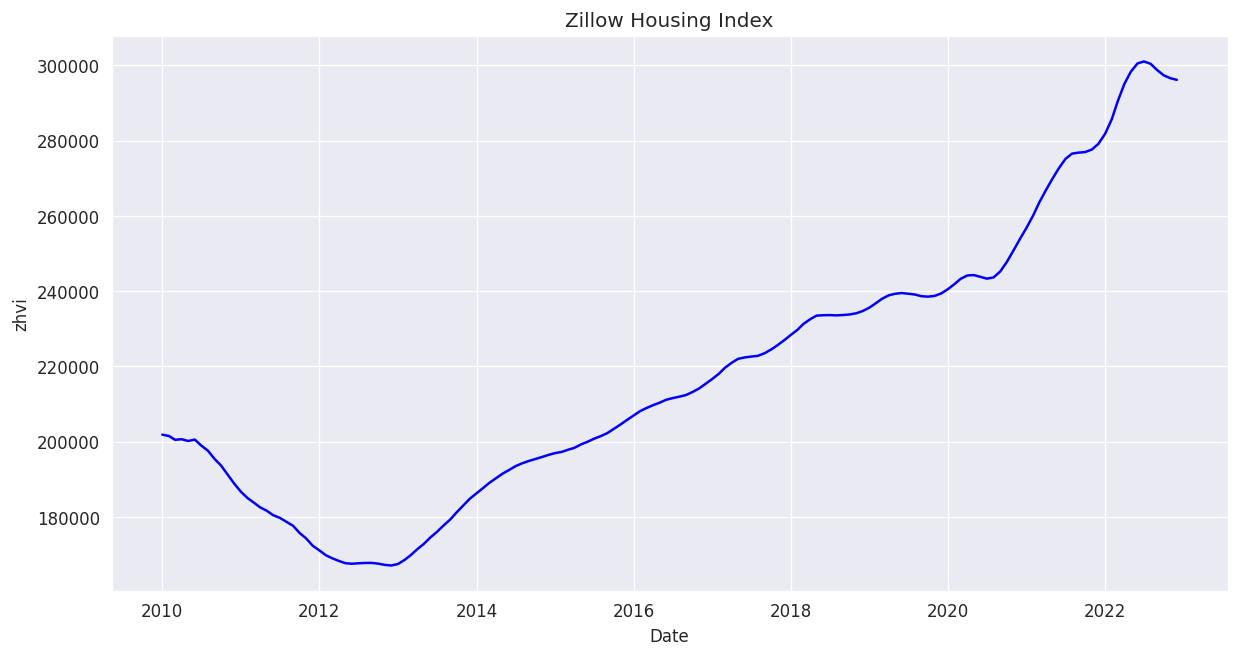

In [167]:
#plot observed values
quick_plot(title = 'Zillow Housing Index', y='zhvi', marker=None,  color = 'blue', df = df)
#quick_plot(title = '40th percentile rent', y='studio', color= 'magenta', df= df)

#other than scaler all hud data is same shape
#quick_plot(data_df[data_df['city']=='Chicago'], '1_bedroom', '40th percentile rent', 'cyan')
#quick_plot(data_df[data_df['city']=='Chicago'], '2_bedroom', '40th percentile rent', 'red')
#quick_plot(data_df[data_df['city']=='Chicago'], '3_bedroom', '40th percentile rent', 'blue')
#quick_plot(data_df[data_df['city']=='Chicago'], '4_bedroom', '40th percentile rent', 'black')

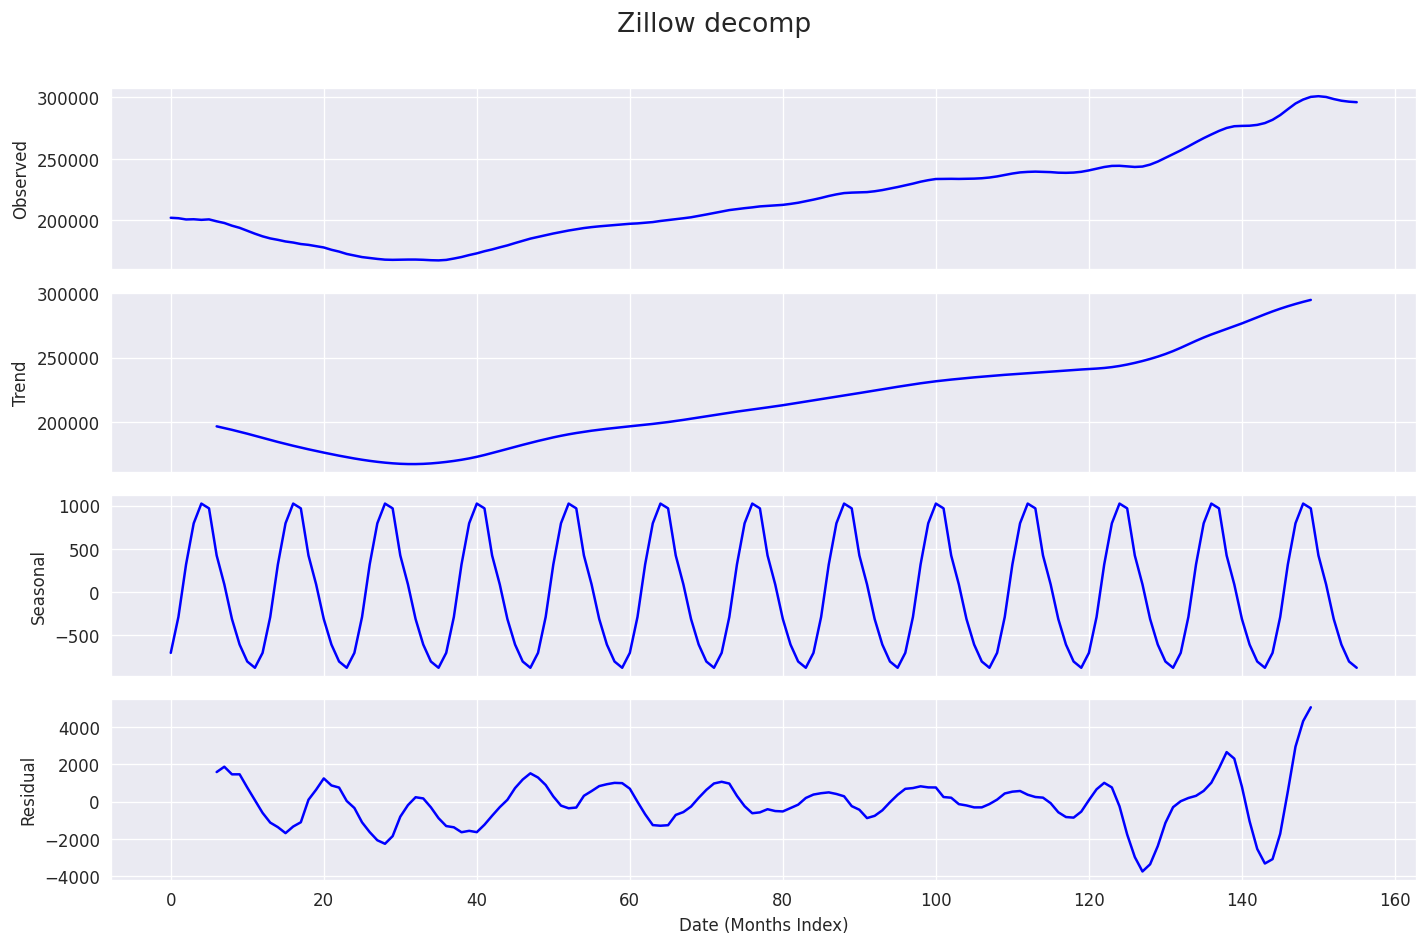

ADF Statistic: -0.3443
p-value: 0.9190
Critical Values: {'1%': -3.4776006742422374, '5%': -2.882265832283648, '10%': -2.5778219289774156}
Fail to reject the null hypothesis. Data has a unit root, indicating non-seasonality. not stationary


In [168]:
#Perform decomposition and test stationarity
plot_decomp(df, 'zhvi', "Zillow decomp", color='blue')
ADF_stationarity_test(df,'zhvi')
#print()
#plot_decomp(df, 'studio', "HUD decomp", color='magenta')
#ADF_stationarity_test(df,'studio')

0
1
2


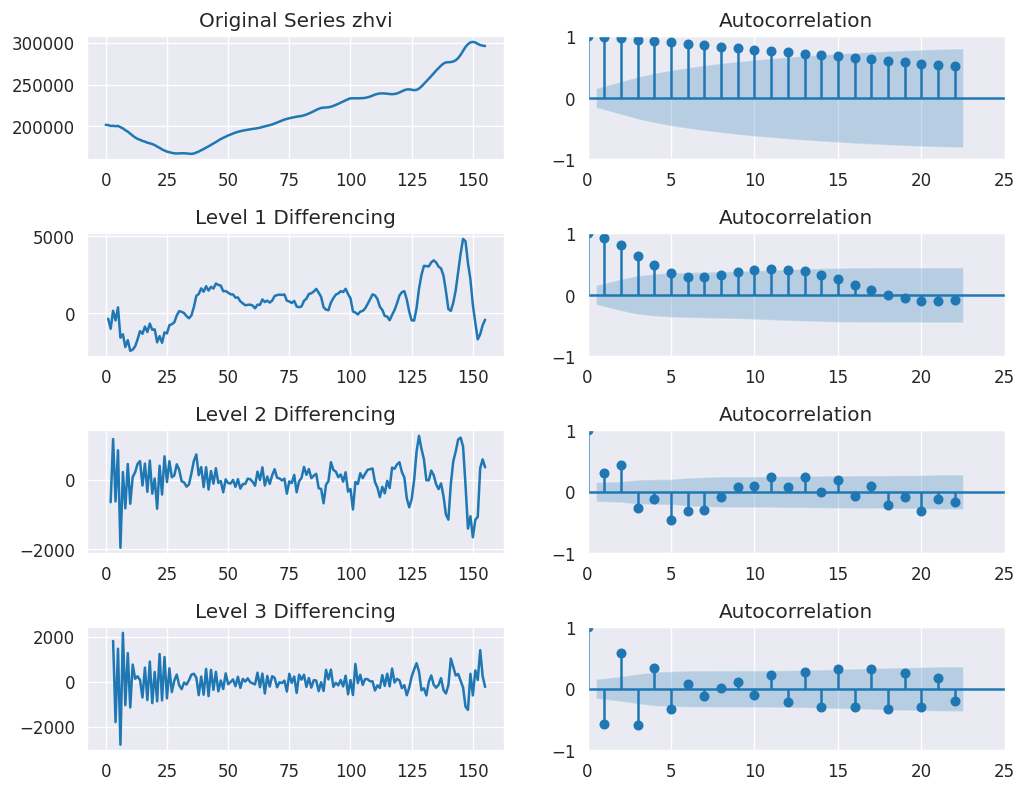

In [169]:
diff_corr_plots(df, 'zhvi',)

> * for data above, stationarity is achieved at 3 levels of differencing

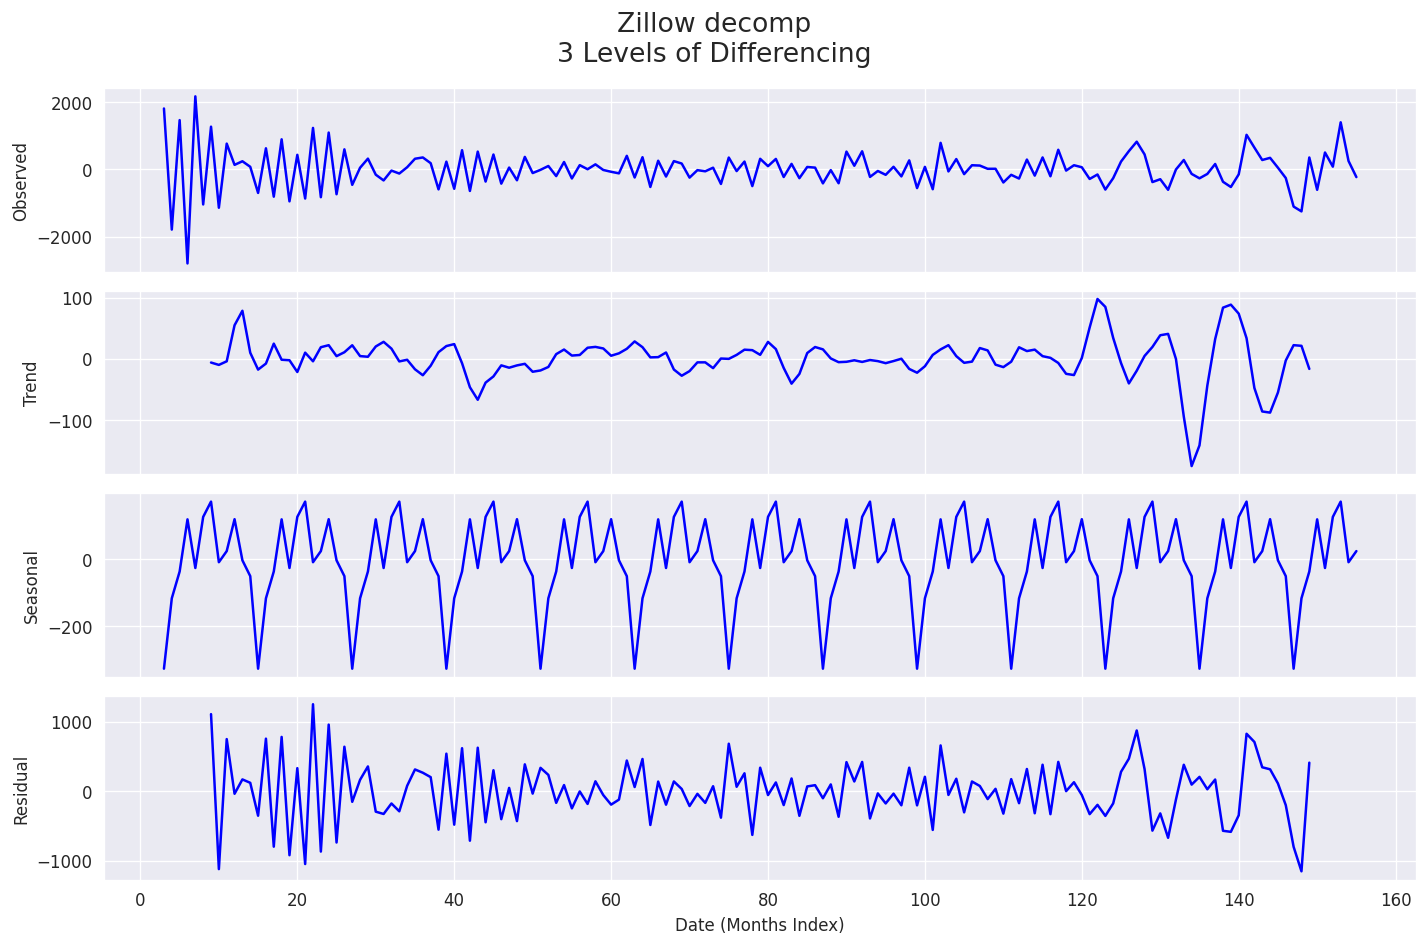

ADF Statistic: -7.2908
p-value: 0.0000
Critical Values: {'1%': -3.4782936965183815, '5%': -2.882567574015525, '10%': -2.5779830117488745}
Reject the null hypothesis. Data has no unit root, indicating seasonality. stationary


In [170]:
df1=df.copy()
df1['zhvi'] = df1['zhvi'].diff().diff().diff().dropna()
df1=df1.dropna()

plot_decomp(df1, 'zhvi', "Zillow decomp\n3 Levels of Differencing", color='blue')
ADF_stationarity_test(df1,'zhvi')

> * we can see that 3 differences does indeed achieve stationarity. there does appear to be some seasonality we'll test if thats significant

## Initial Arima modeling

In [171]:
split_percent=0.8
train_size = int(len(df) * split_percent)
to_predict= 'zhvi'

# top features determined by importance analysis in lstm notebooks
city_features = {
  'Chicago'     : ["rdfn_open", "passenger_domestic_outbound", "cbre_close", "a_mean", "studio"],
  'Dallas'      : [ "cbre_high", "oop_moved_from_different_state", "ROP_moved_From_different_county", "population_in_housing_units", "studio"],
  'Los Angeles' : ["rdfn_volume", "cargo_intl_outbound", "cbre_high", "passenger_intl_inbound", "studio"],
  'New York'    : ["passenger_domestic_inbound", "rdfn_high", "cbre_high", "rdfn_adj close", "studio"],
  'Seattle'     : ["cbre_high", "rop_moved_from_abroad", "violentcrimeincident", "tot_emp", "studio"]
}


### Baseline (Univariate)

,date,zhvi,prediction,lower,upper
0,2010-01-01,201888.606600,201798.319286,NaN,NaN
1,2010-02-01,201527.551140,201799.219156,NaN,NaN
2,2010-03-01,200518.003420,201007.027531,NaN,NaN
3,2010-04-01,200674.643669,199797.420943,NaN,NaN
4,2010-05-01,200205.154396,200480.911669,NaN,NaN
...,...,...,...,...,...
151,2022-08-01,300423.033179,261491.091481,188416.025827,334566.157135
152,2022-09-01,298728.977859,262106.328567,185076.399136,339136.257999
153,2022-10-01,297366.608656,262721.564279,181667.918559,343775.209999
154,2022-11-01,296587.572167,263336.800890,178191.743928,348481.857852


AIC = 1714
BIC = 1725
p = 1
d = 2
q = 2
P = 0
D = 0
Q = 0
sp = 1


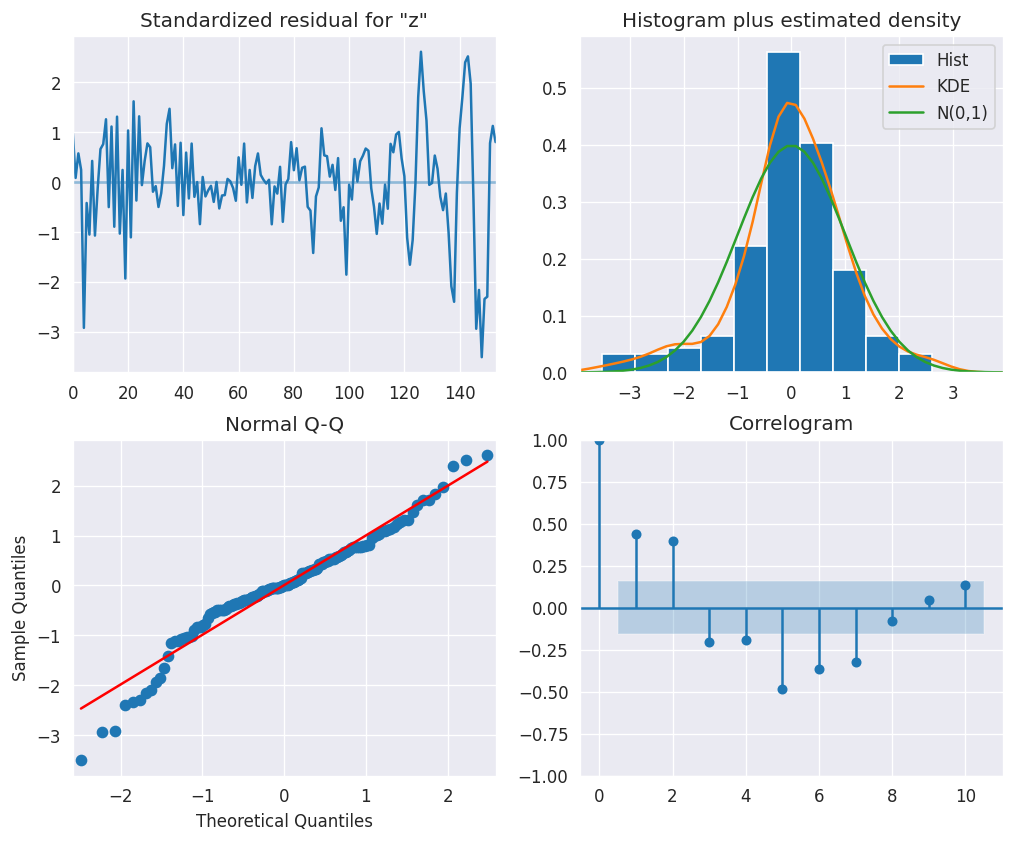

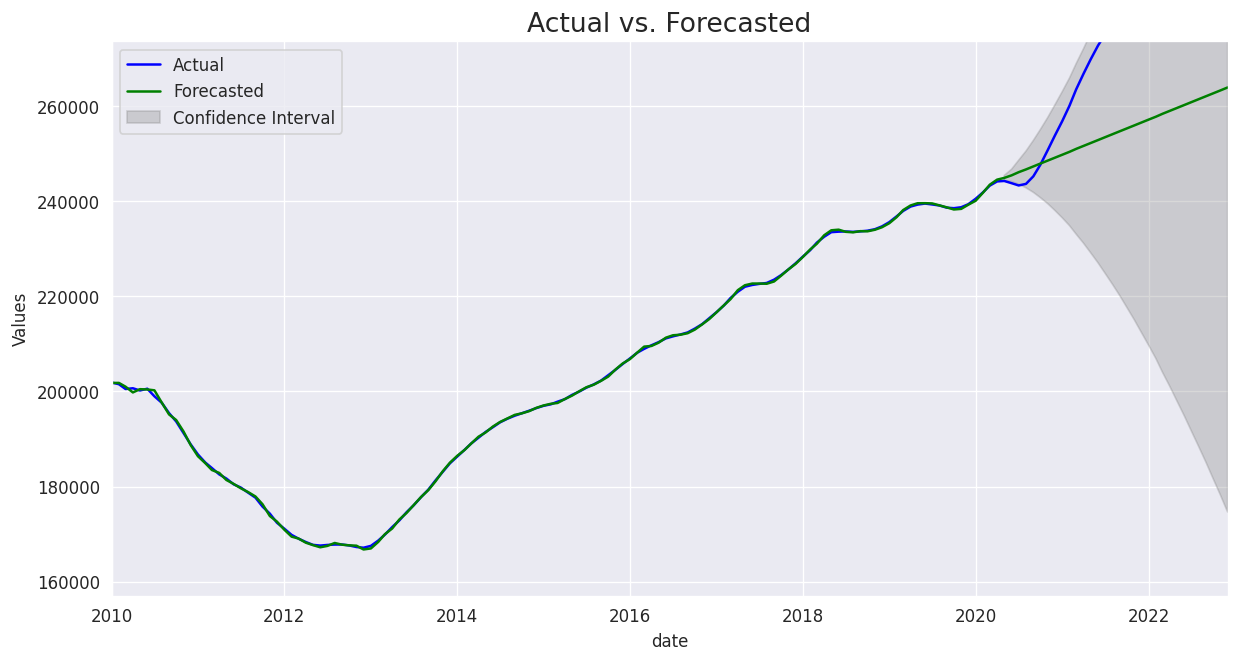

Symmetric Mean Absolute Percentage Error (SMAPE): 7.4215
SMAPE of 7.4215 suggests that, on average, our forecasts deviate by about 7.4215% from the actual values in a symmetric manner.

Geometric Mean Relative Absolute Error (GMRAE): 4.7963
A GMRAE value of 4.7963 indicates that, on average, the forecasted values have an error of approximately 4.7963% relative to the actual values.

Root Mean Squared Error (RMSE): 24258.7459
RMSE of 24258.7459 suggests that, on average, the forecasts are off by about 24258.7459 units from the actual values.

Root Mean Squared Error (MSE): 588486754.2200
MSE of 588486754.2200 suggests that, on average, the forecasts are off by about 588486754.2200 squared units from the actual values.



In [172]:
accuracy_metrics = {"rmse":True, 'gmrae':True, 'smape':True, 'mse':True }
arima_forecast, param_dict = auto_arima_model(df,to_predict, split_percent=split_percent )
diagnostic_plot(arima_forecast, param_dict )
arima_fit_plot(arima_forecast, 'date', to_predict )
metrics=arima_accuracy_metrics(arima_forecast.iloc[train_size:],to_predict, **accuracy_metrics)

### Univariate Param Search

Fitting models using approximations to speed things up

ARIMA(2,2,3)(1,0,2)[15]                   :inf

ARIMA(0,2,0)                   :1802.1104333309827

ARIMA(1,2,0)(1,0,0)[15]                   :1813.3986045347124

ARIMA(0,2,1)(0,0,1)[15]                   :1789.7690838926273

ARIMA(0,2,1)                   :1801.1809221432593

ARIMA(0,2,1)(1,0,1)[15]                   :1813.8550263094949

ARIMA(0,2,1)(0,0,2)[15]                   :1788.5167014152948

ARIMA(0,2,1)(1,0,2)[15]                   :1805.904295601144

ARIMA(0,2,0)(0,0,2)[15]                   :1788.8275824562302

ARIMA(1,2,1)(0,0,2)[15]                   :1790.4951473808082

ARIMA(0,2,2)(0,0,2)[15]                   :1757.3564920542362

ARIMA(0,2,2)(0,0,1)[15]                   :1757.5736201831455

ARIMA(0,2,2)(1,0,2)[15]                   :1774.194679546228

ARIMA(0,2,2)(1,0,1)[15]                   :1774.9830223231638

ARIMA(1,2,2)(0,0,2)[15]                   :1712.4804095544325

ARIMA(1,2,2)(0,0,1)[15]               

,date,zhvi,prediction,lower,upper
0,2010-01-01,201888.606600,201798.319287,NaN,NaN
1,2010-02-01,201527.551140,201799.219117,NaN,NaN
2,2010-03-01,200518.003420,200995.465147,NaN,NaN
3,2010-04-01,200674.643669,199832.287435,NaN,NaN
4,2010-05-01,200205.154396,200455.811153,NaN,NaN
...,...,...,...,...,...
151,2022-08-01,300423.033179,265199.154490,195815.320819,334582.988161
152,2022-09-01,298728.977859,265753.548718,192623.874864,338883.222571
153,2022-10-01,297366.608656,266428.324935,189487.913505,343368.736364
154,2022-11-01,296587.572167,267118.043841,186343.648836,347892.438846


AIC = 1712
BIC = 1729
p = 1
d = 2
q = 2
P = 0
D = 0
Q = 2
sp = 15


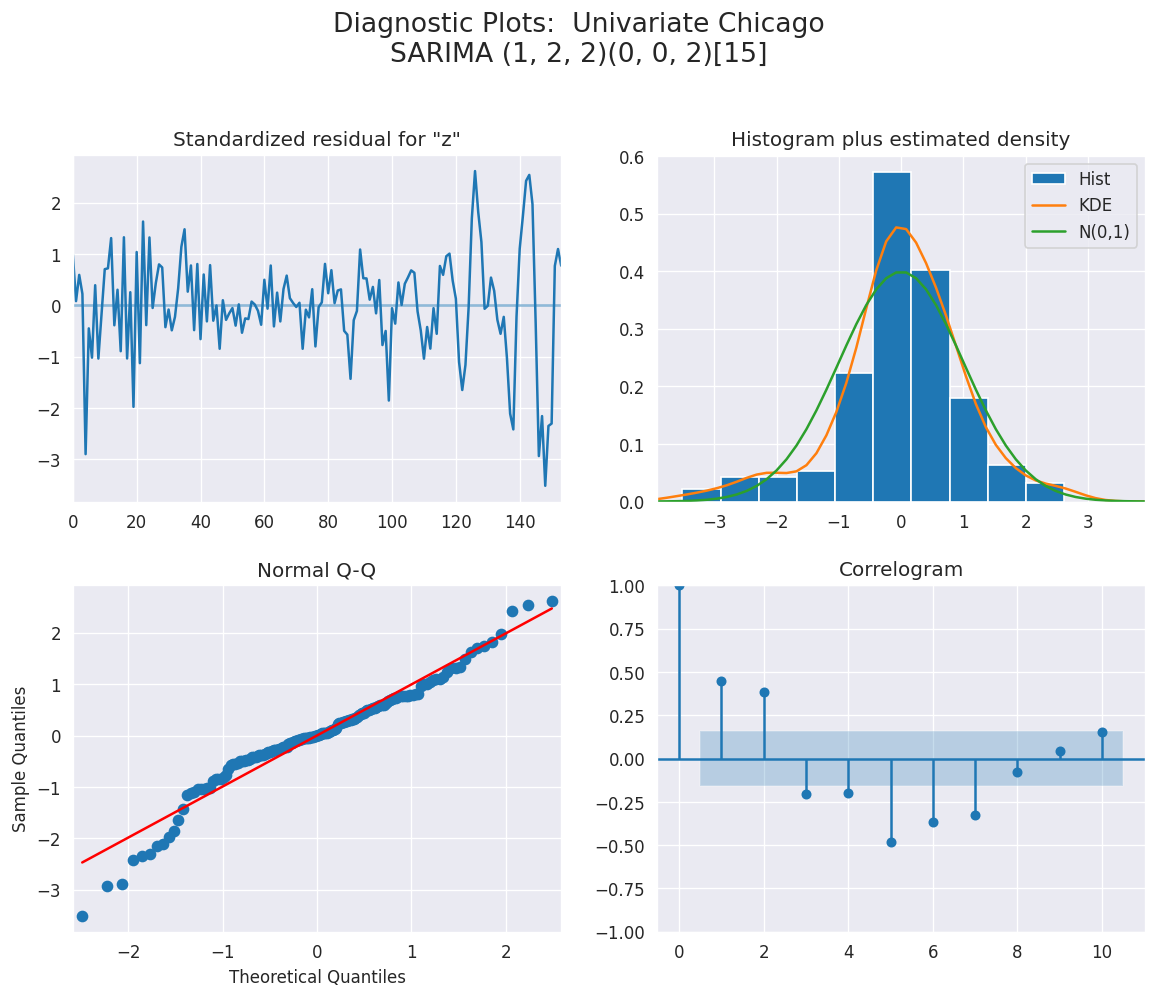


Mean Squared Error (MSE): 485573004.0840
MSE of 485573004.0840 suggests that, on average, the forecasts are off by about 22035.7211 dollars from the actual values.




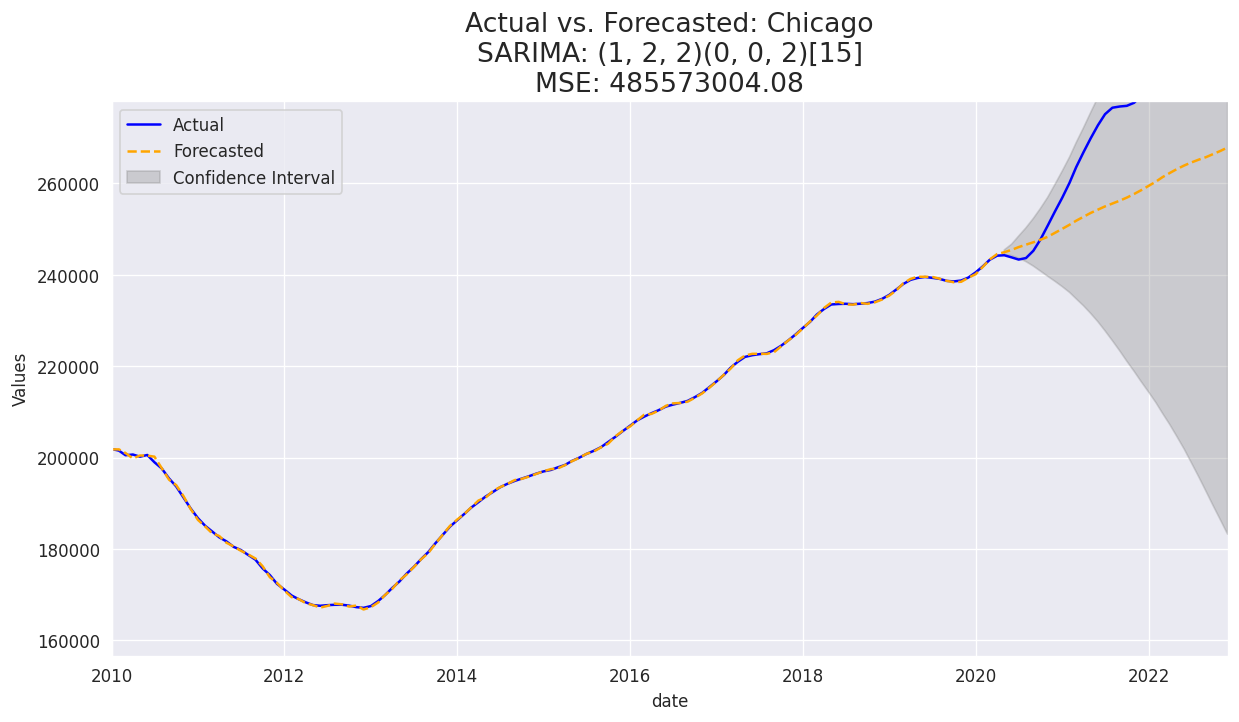

In [201]:
sp= 15 #[3,4,12,15]
params={
    'start_p':2,
    'start_q':3,
    'start_P': 1,
    'start_Q': 2,
    'test':'adf',       # use adftest to find optimal 'd'
    'seasonal_test':'seas',
    'max_p':4, 'max_q':5, # maximum p and q
    'max_P': sp, 'max_Q': sp,
    'max_d': 3, 'max_D': 3,
    'd':None,           # let model determine 'd'
    'seasonal':True,   # No Seasonality
    'sp':sp,              # frequency of series
    'D':None,
    'trace':True,
    'stepwise':True,
    'parallel':True,
    'information_criterion':'aicc',
    'approximation':True,
    'method':'CSS-ML',
    'max_order':20,
    'n_fits':300,

}


accuracy_metrics = {"rmse":False, 'gmrae':False, 'smape':False, 'mse':True, 'rmse':False }
arima_forecast, param_dict = auto_arima_model(df,to_predict, split_percent=split_percent, **params )
model_str=f"({param_dict['p']}, {param_dict['d']}, {param_dict['q']})({param_dict['P']}, {param_dict['D']}, {param_dict['Q']})[{param_dict['sp']}]"
diagnostic_plot(arima_forecast, param_dict, add_text=f' {city}\nSARIMA {model_str}' )
print()
metrics=arima_accuracy_metrics(arima_forecast.iloc[train_size:], to_predict, **accuracy_metrics)
print()
arima_fit_plot(arima_forecast, 'date', to_predict,add_text=f': {city}\nSARIMA: {model_str}\nMSE: {metrics["mse"]:.2f}' )


> looks like theres quite a large room for error. we'll try some exogenous features

### Arima with Exogenous Variables

Fitting models using approximations to speed things up

Regression with ARIMA(2,0,3)(1,0,2)[15] errors:inf

Regression with ARIMA(0,0,0) errors:2579.169550416871

Regression with ARIMA(1,0,0)(1,0,0)[15] errors:inf

Regression with ARIMA(0,0,1)(0,0,1)[15] errors:2457.286117888246

Regression with ARIMA(0,0,0) errors:2580.6011822435985

Regression with ARIMA(0,0,1) errors:2463.0237471052765

Regression with ARIMA(0,0,1)(1,0,1)[15] errors:inf

Regression with ARIMA(0,0,1)(0,0,2)[15] errors:2448.3454982775997

Regression with ARIMA(0,0,1)(1,0,2)[15] errors:inf

Regression with ARIMA(0,0,0)(0,0,2)[15] errors:inf

Regression with ARIMA(1,0,1)(0,0,2)[15] errors:inf

Regression with ARIMA(0,0,2)(0,0,2)[15] errors:inf

Regression with ARIMA(1,0,0)(0,0,2)[15] errors:inf

Regression with ARIMA(1,0,2)(0,0,2)[15] errors:inf

Regression with ARIMA(0,0,1)(0,0,2)[15] errors:2448.3454982775997
Now re-fitting the best model(s) without approximations...


Regression with ARIMA(0,0,1)(0,0,2)[15] errors:24

,date,zhvi,rdfn_open,passenger_domestic_outbound,cbre_close,a_mean,studio,prediction,lower,upper
0,2010-01-01,201888.606600,0.00,168.0,12.30,49140.0,765.730804,188703.081402,NaN,NaN
1,2010-02-01,201527.551140,0.00,165.0,13.20,49140.0,765.730804,197769.377501,NaN,NaN
2,2010-03-01,200518.003420,0.00,160.0,15.85,49140.0,765.730804,187963.807049,NaN,NaN
3,2010-04-01,200674.643669,0.00,168.0,17.32,49140.0,765.730804,195567.112896,NaN,NaN
4,2010-05-01,200205.154396,0.00,159.0,15.83,49140.0,765.730804,188953.718977,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
151,2022-08-01,300423.033179,8.56,200.0,78.96,66170.0,1017.694818,285429.401836,273967.103922,296891.699750
152,2022-09-01,298728.977859,8.02,190.0,67.51,66170.0,1017.694818,274639.008616,263176.779171,286101.238060
153,2022-10-01,297366.608656,5.92,182.0,70.94,66170.0,1017.694818,275997.240256,264535.010811,287459.469700
154,2022-11-01,296587.572167,5.00,175.0,79.60,66170.0,1017.694818,281379.245778,269553.620124,293204.871432


AIC = 2452
BIC = 2476
p = 0
d = 0
q = 1
P = 0
D = 0
Q = 2
sp = 15


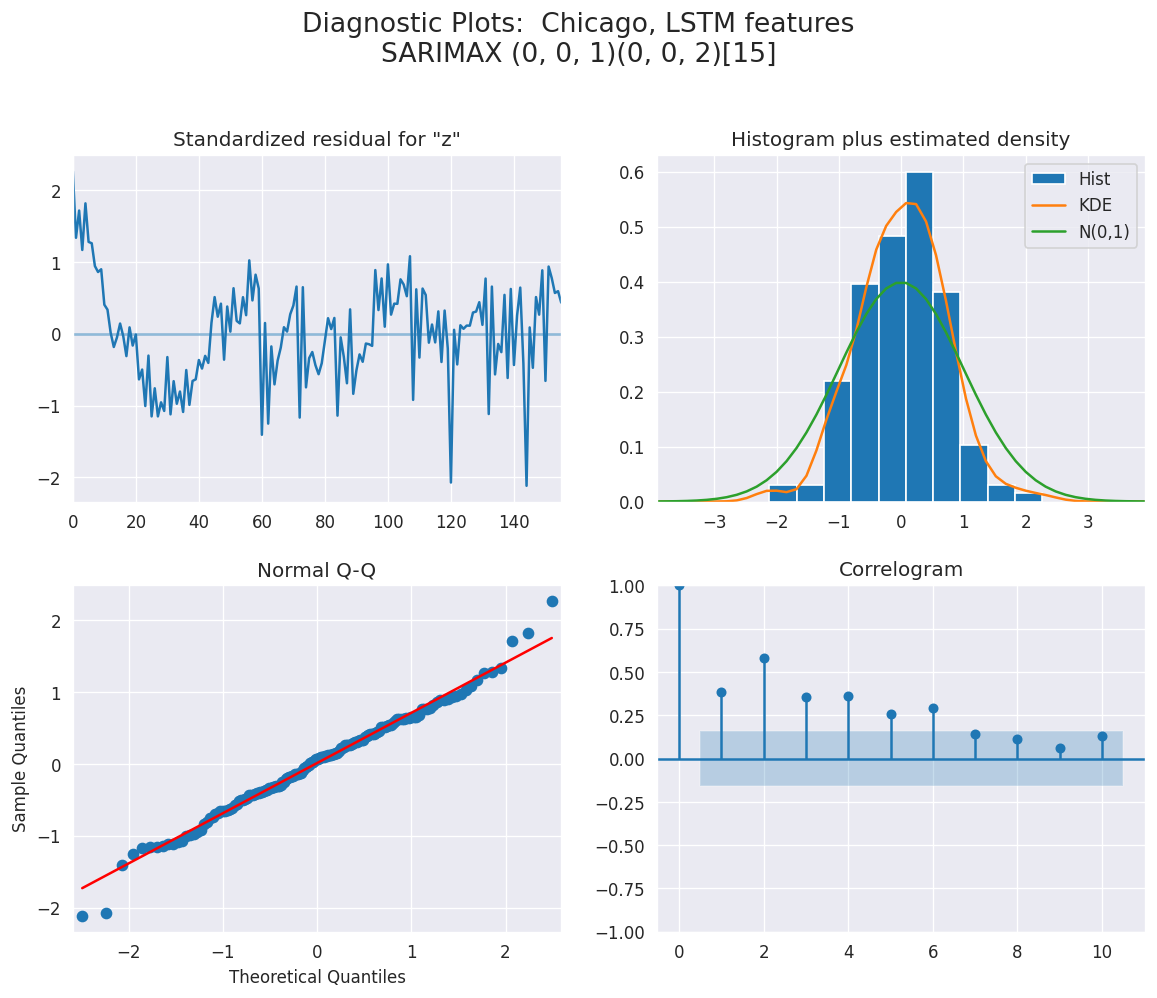


Mean Squared Error (MSE): 254378059.4397
MSE of 254378059.4397 suggests that, on average, the forecasts are off by about 15949.2338 dollars from the actual values.




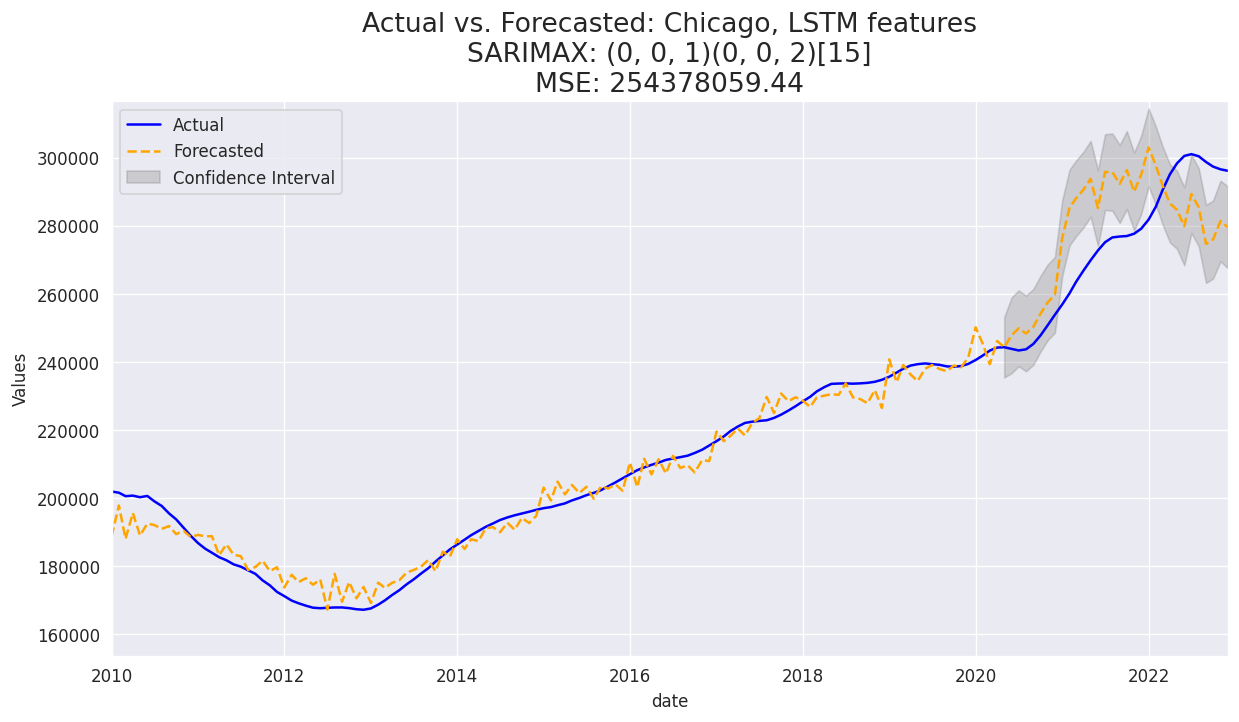

In [203]:
x_df=df[city_features[city]].copy()

accuracy_metrics = {"rmse":False, 'gmrae':False, 'smape':False, 'mse':True, 'rmse':False }
arima_forecast, param_dict = auto_arima_model(df,to_predict, x_df, split_percent=split_percent, **params )
model_str=f"({param_dict['p']}, {param_dict['d']}, {param_dict['q']})({param_dict['P']}, {param_dict['D']}, {param_dict['Q']})[{param_dict['sp']}]"
diagnostic_plot(arima_forecast, param_dict, add_text=f' {city}, LSTM features\nSARIMAX {model_str}' )
print()
metrics=arima_accuracy_metrics(arima_forecast.iloc[train_size:], to_predict, **accuracy_metrics)
print()
arima_fit_plot(arima_forecast, 'date', to_predict,add_text=f': {city}, LSTM features\nSARIMAX: {model_str}\nMSE: {metrics["mse"]:.2f}' )

## Multivariate Modeling

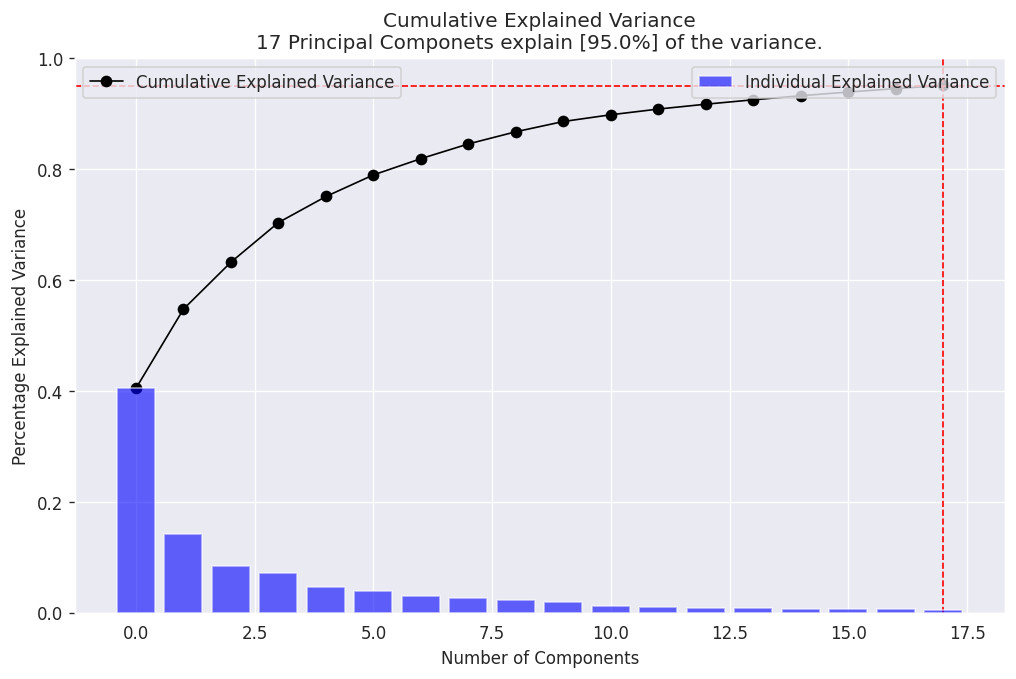

In [175]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler




target = 'zhvi'
explained_percent = 0.95

pipe = Pipeline(
    [
        ("city_filter_scale", XyCitySelectScale(city=city, target_column=target, scaler = StandardScaler)),
        ("pca", PCA(n_components=explained_percent, svd_solver='full', random_state=SEED)),
    ]
)



X_pca =  pipe.fit_transform(data_z.set_index('date'))
pca = pipe.named_steps['pca']
y = pipe.named_steps['city_filter_scale'].get_target()
filtered_index = pipe.named_steps['city_filter_scale'].get_index()

explained_var_plot(pca, explained_percent)

['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18']
Fitting models using approximations to speed things up

Regression with ARIMA(2,0,3)(1,0,2)[15] errors:inf

Regression with ARIMA(0,0,0) errors:-189.6222942770363

Regression with ARIMA(1,0,0)(1,0,0)[15] errors:inf

Regression with ARIMA(0,0,1)(0,0,1)[15] errors:-226.6295170910424

Regression with ARIMA(0,0,0) errors:-161.51176408047615

Regression with ARIMA(0,0,1) errors:-223.59518506911763

Regression with ARIMA(0,0,1)(1,0,1)[15] errors:-225.38286410036054

Regression with ARIMA(0,0,1)(0,0,2)[15] errors:-238.70663278606642

Regression with ARIMA(0,0,1)(1,0,2)[15] errors:-236.28335742239932

Regression with ARIMA(0,0,0)(0,0,2)[15] errors:-200.4461211862052

Regression with ARIMA(1,0,1)(0,0,2)[15] errors:-599.5307340416949

Regression with ARIMA(1,0,1)(0,0,1)[15] errors:-602.5262814805926

Regression with ARIMA(1,0,1) errors:-575.6140585344046

Regres

,date,zhvi,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,prediction,lower,upper
0,2010-01-01,-0.431417,-7.069041,-5.057980,4.103932,-1.420185,2.926250,1.356084,0.713924,-1.854977,-1.290324,-1.484335,0.579941,-0.135259,-1.034712,-0.321500,-0.268873,0.380919,0.403176,1.197933,-0.420499,NaN,NaN
1,2010-02-01,-0.441256,-6.765461,-5.055822,4.872761,-0.963570,2.444052,1.113783,0.171021,-2.082439,-0.668481,-1.451323,0.098796,1.081889,-0.207800,-0.306550,-0.094844,0.879204,1.318675,-0.180918,-0.435070,NaN,NaN
2,2010-03-01,-0.468766,-6.763727,-5.544445,1.184901,0.264534,1.797125,0.856442,0.232503,-2.598741,-0.682116,-1.404186,1.527923,-0.910572,0.118068,-1.066505,-0.002978,0.043584,-0.065927,-0.389082,-0.455552,NaN,NaN
3,2010-04-01,-0.464497,-6.287901,-5.640500,-0.582017,1.059147,0.535734,1.634173,-0.722787,-2.568074,-0.912981,-0.382494,0.692995,0.644847,0.791694,-1.081606,-0.041687,0.329686,-0.302970,-0.214251,-0.476700,NaN,NaN
4,2010-05-01,-0.477291,-6.398794,-5.988170,-1.340979,1.438477,1.411737,0.558581,0.436716,-2.139361,0.245632,-1.846698,0.837627,0.001662,1.215938,-1.066785,0.198398,0.543768,-0.394034,-0.797561,-0.459922,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,2022-08-01,2.253597,6.182227,-1.803294,-3.662266,-4.579921,-1.373689,3.110170,-0.321113,1.510679,-0.008480,-1.035293,-0.028346,1.227027,-1.657428,-0.082230,-0.238154,-0.193465,0.542040,0.167460,0.671533,0.264230,1.078837
152,2022-09-01,2.207435,6.142616,-2.423857,-2.728828,-3.169611,-1.320000,2.172195,-0.178094,-0.598571,2.089088,-1.576111,1.034053,-0.907535,-1.835385,1.051334,-0.962582,0.688877,0.313712,-1.041300,0.662844,0.244523,1.081165
153,2022-10-01,2.170311,4.934195,-3.097828,-0.776955,-3.081926,-1.916536,4.416096,-2.043382,0.447732,1.632831,-1.028530,0.774573,-0.225849,-0.697090,0.677224,-0.380025,-0.980680,-0.099451,0.235227,0.666764,0.237762,1.095766
154,2022-11-01,2.149083,5.477355,-3.187185,0.485252,-3.603945,-1.884253,5.068029,-2.096836,0.240394,2.095861,-0.802824,0.487173,-0.294539,-1.151133,0.966036,-0.292058,-0.714299,-0.571050,-0.261323,0.659920,0.220550,1.099290


AIC = -606
BIC = -553
p = 1
d = 0
q = 1
P = 0
D = 0
Q = 1
sp = 15


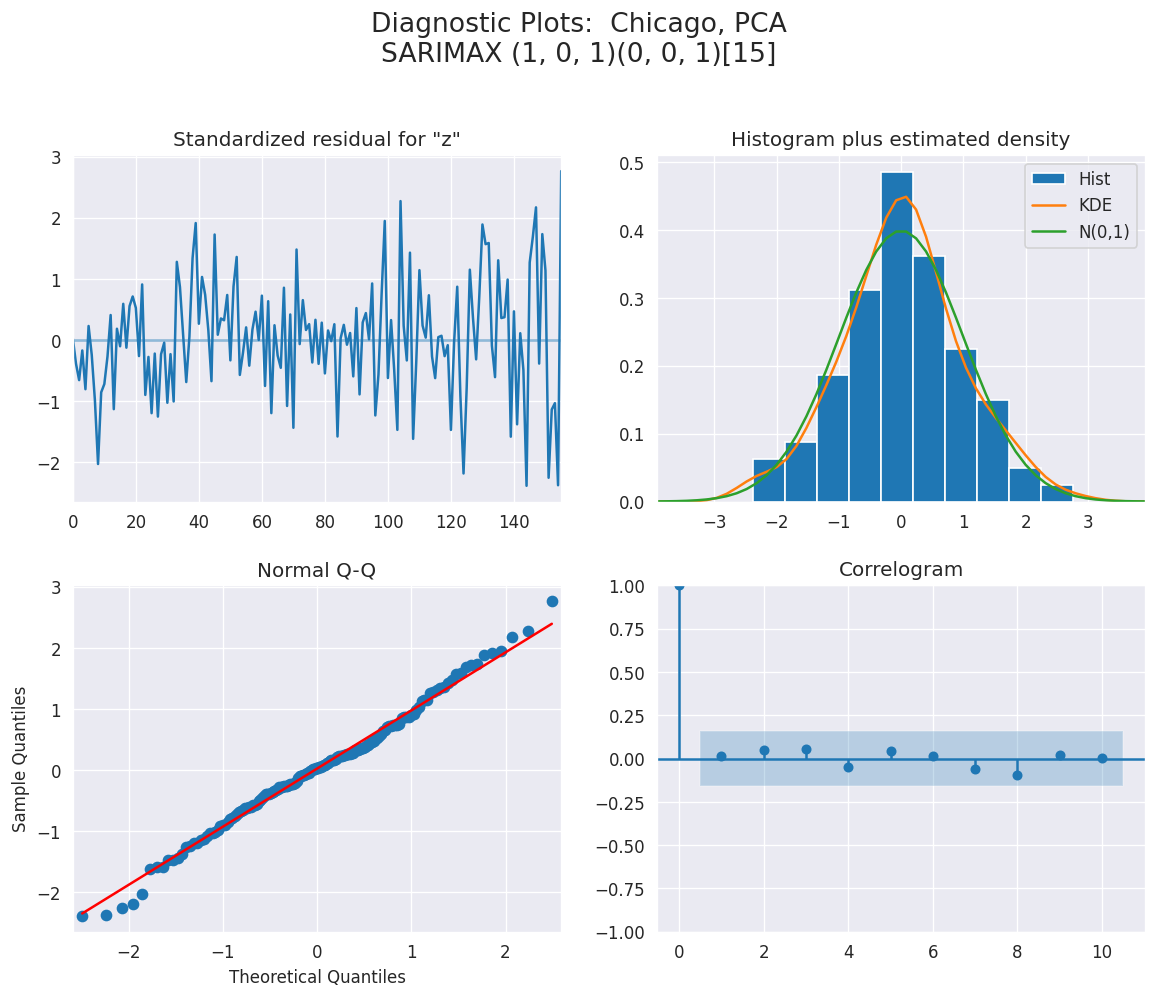


Mean Squared Error (MSE): 1.0181
MSE of 1.0181 suggests that, on average, the forecasts are off by about 1.0090 dollars from the actual values.




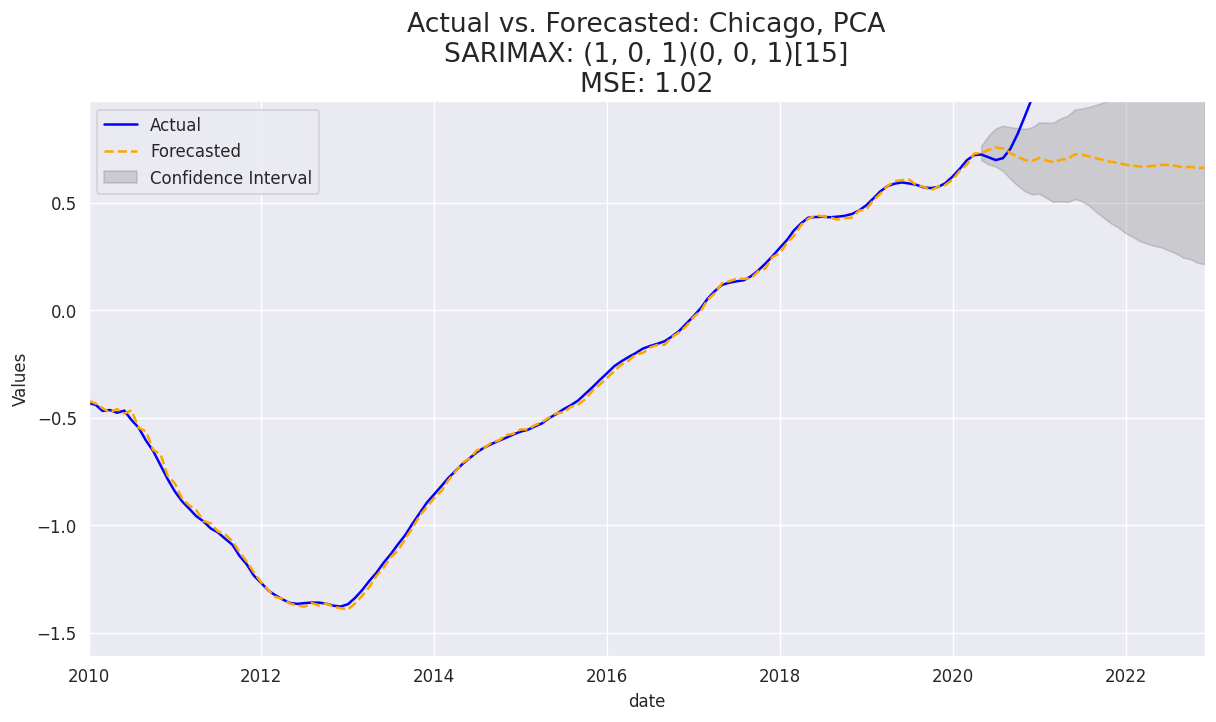

In [204]:
pca_df = pd.DataFrame(X_pca, index=filtered_index, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])]).reset_index()
columns=list(pca_df.columns)[1:]
print(columns)
pca_df[target] = y

accuracy_metrics = {"rmse":False, 'gmrae':False, 'smape':False, 'mse':True, 'rmse':False }
arima_forecast, param_dict = auto_arima_model(pca_df,target, pca_df[columns], split_percent=split_percent, **params )
model_str=f"({param_dict['p']}, {param_dict['d']}, {param_dict['q']})({param_dict['P']}, {param_dict['D']}, {param_dict['Q']})[{param_dict['sp']}]"
diagnostic_plot(arima_forecast, param_dict, add_text=f' {city}, PCA\nSARIMAX {model_str}' )
print()
metrics=arima_accuracy_metrics(arima_forecast.iloc[train_size:], target, **accuracy_metrics)
print()
arima_fit_plot(arima_forecast, 'date', target,add_text=f': {city}, PCA\nSARIMAX: {model_str}\nMSE: {metrics["mse"]:.2f}' )

['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18']
Fitting models using approximations to speed things up

Regression with ARIMA(2,0,3)(1,0,2)[15] errors:inf

Regression with ARIMA(0,0,0) errors:-189.6222942770363

Regression with ARIMA(1,0,0)(1,0,0)[15] errors:inf

Regression with ARIMA(0,0,1)(0,0,1)[15] errors:-226.6295170910424

Regression with ARIMA(0,0,0) errors:-161.51176408047615

Regression with ARIMA(0,0,1) errors:-223.59518506911763

Regression with ARIMA(0,0,1)(1,0,1)[15] errors:-225.38286410036054

Regression with ARIMA(0,0,1)(0,0,2)[15] errors:-238.70663278606642

Regression with ARIMA(0,0,1)(1,0,2)[15] errors:-236.28335742239932

Regression with ARIMA(0,0,0)(0,0,2)[15] errors:-200.4461211862052

Regression with ARIMA(1,0,1)(0,0,2)[15] errors:-599.5307340416949

Regression with ARIMA(1,0,1)(0,0,1)[15] errors:-602.5262814805926

Regression with ARIMA(1,0,1) errors:-575.6140585344046

Regres

,date,zhvi,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,prediction,lower,upper
0,2010-01-01,-0.431417,-7.069041,-5.057980,4.103932,-1.420185,2.926250,1.356084,0.713924,-1.854977,-1.290324,-1.484335,0.579941,-0.135259,-1.034712,-0.321500,-0.268873,0.380919,0.403176,1.197933,-0.420499,NaN,NaN
1,2010-02-01,-0.441256,-6.765461,-5.055822,4.872761,-0.963570,2.444052,1.113783,0.171021,-2.082439,-0.668481,-1.451323,0.098796,1.081889,-0.207800,-0.306550,-0.094844,0.879204,1.318675,-0.180918,-0.435070,NaN,NaN
2,2010-03-01,-0.468766,-6.763727,-5.544445,1.184901,0.264534,1.797125,0.856442,0.232503,-2.598741,-0.682116,-1.404186,1.527923,-0.910572,0.118068,-1.066505,-0.002978,0.043584,-0.065927,-0.389082,-0.455552,NaN,NaN
3,2010-04-01,-0.464497,-6.287901,-5.640500,-0.582017,1.059147,0.535734,1.634173,-0.722787,-2.568074,-0.912981,-0.382494,0.692995,0.644847,0.791694,-1.081606,-0.041687,0.329686,-0.302970,-0.214251,-0.476700,NaN,NaN
4,2010-05-01,-0.477291,-6.398794,-5.988170,-1.340979,1.438477,1.411737,0.558581,0.436716,-2.139361,0.245632,-1.846698,0.837627,0.001662,1.215938,-1.066785,0.198398,0.543768,-0.394034,-0.797561,-0.459922,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,2022-08-01,2.253597,6.182227,-1.803294,-3.662266,-4.579921,-1.373689,3.110170,-0.321113,1.510679,-0.008480,-1.035293,-0.028346,1.227027,-1.657428,-0.082230,-0.238154,-0.193465,0.542040,0.167460,0.671533,0.264230,1.078837
152,2022-09-01,2.207435,6.142616,-2.423857,-2.728828,-3.169611,-1.320000,2.172195,-0.178094,-0.598571,2.089088,-1.576111,1.034053,-0.907535,-1.835385,1.051334,-0.962582,0.688877,0.313712,-1.041300,0.662844,0.244523,1.081165
153,2022-10-01,2.170311,4.934195,-3.097828,-0.776955,-3.081926,-1.916536,4.416096,-2.043382,0.447732,1.632831,-1.028530,0.774573,-0.225849,-0.697090,0.677224,-0.380025,-0.980680,-0.099451,0.235227,0.666764,0.237762,1.095766
154,2022-11-01,2.149083,5.477355,-3.187185,0.485252,-3.603945,-1.884253,5.068029,-2.096836,0.240394,2.095861,-0.802824,0.487173,-0.294539,-1.151133,0.966036,-0.292058,-0.714299,-0.571050,-0.261323,0.659920,0.220550,1.099290


AIC = -606
BIC = -553
p = 1
d = 0
q = 1
P = 0
D = 0
Q = 1
sp = 15


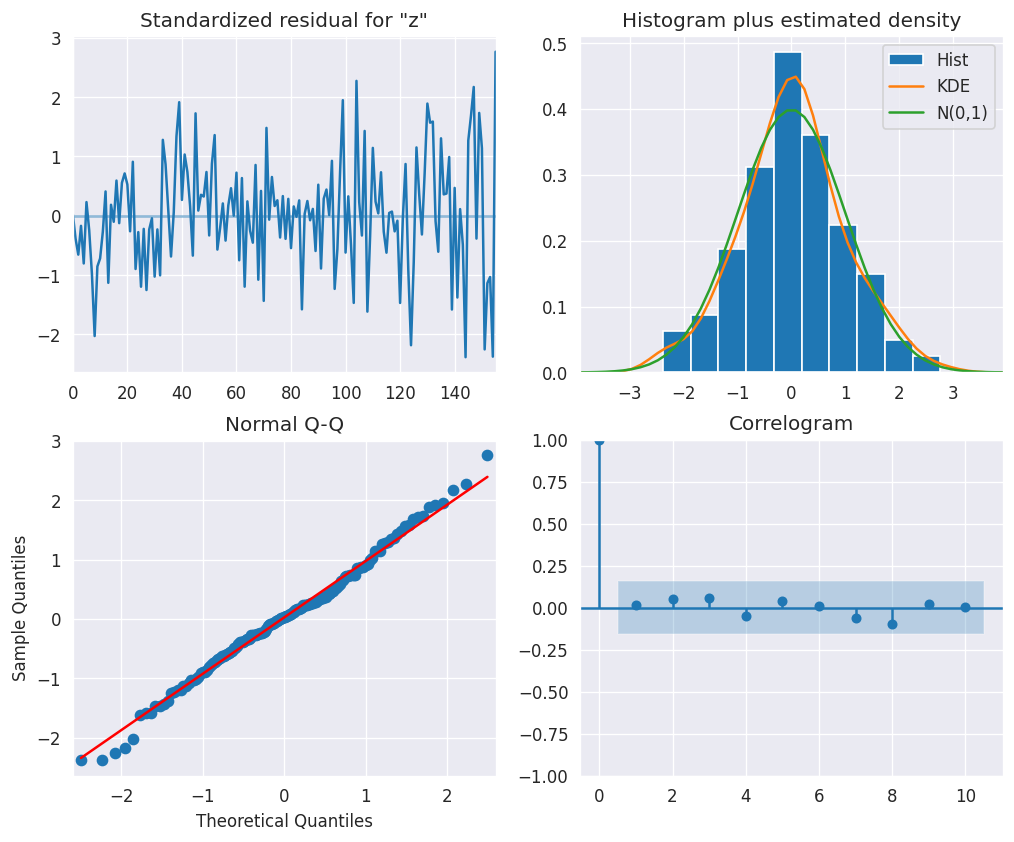

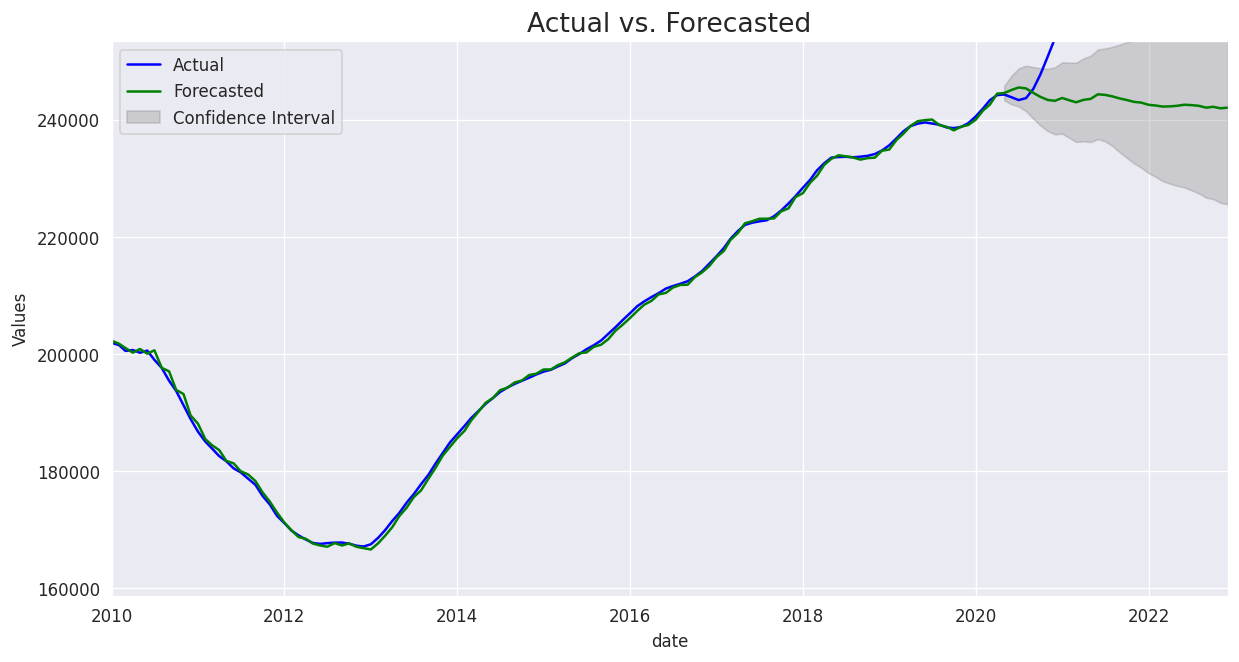

Symmetric Mean Absolute Percentage Error (SMAPE): 11.7195
SMAPE of 11.7195 suggests that, on average, our forecasts deviate by about 11.7195% from the actual values in a symmetric manner.

Geometric Mean Relative Absolute Error (GMRAE): 7.3516
A GMRAE value of 7.3516 indicates that, on average, the forecasted values have an error of approximately 7.3516% relative to the actual values.

Root Mean Squared Error (RMSE): 37028.0749
RMSE of 37028.0749 suggests that, on average, the forecasts are off by about 37028.0749 units from the actual values.

Root Mean Squared Error (MSE): 1371078333.3838
MSE of 1371078333.3838 suggests that, on average, the forecasts are off by about 1371078333.3838 squared units from the actual values.



In [177]:
pca_df = pd.DataFrame(X_pca, index=filtered_index, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])]).reset_index()
columns=list(pca_df.columns)[1:]
print(columns)
pca_df[target] = y


accuracy_metrics = {"rmse":False, 'gmrae':False, 'smape':False, 'mse':True, 'rmse':False }
arima_forecast, param_dict = auto_arima_model(pca_df,target, pca_df[columns], split_percent=split_percent, **params )
rescale = [target, 'prediction', 'lower', 'upper']
for var in rescale:
  arima_forecast[var] = pipe.named_steps['city_filter_scale'].inverse_transform_y(arima_forecast[var], target)

diagnostic_plot(arima_forecast, param_dict )
arima_fit_plot(arima_forecast, 'date',  target )
metrics=arima_accuracy_metrics(arima_forecast.iloc[train_size:],target, **accuracy_metrics)

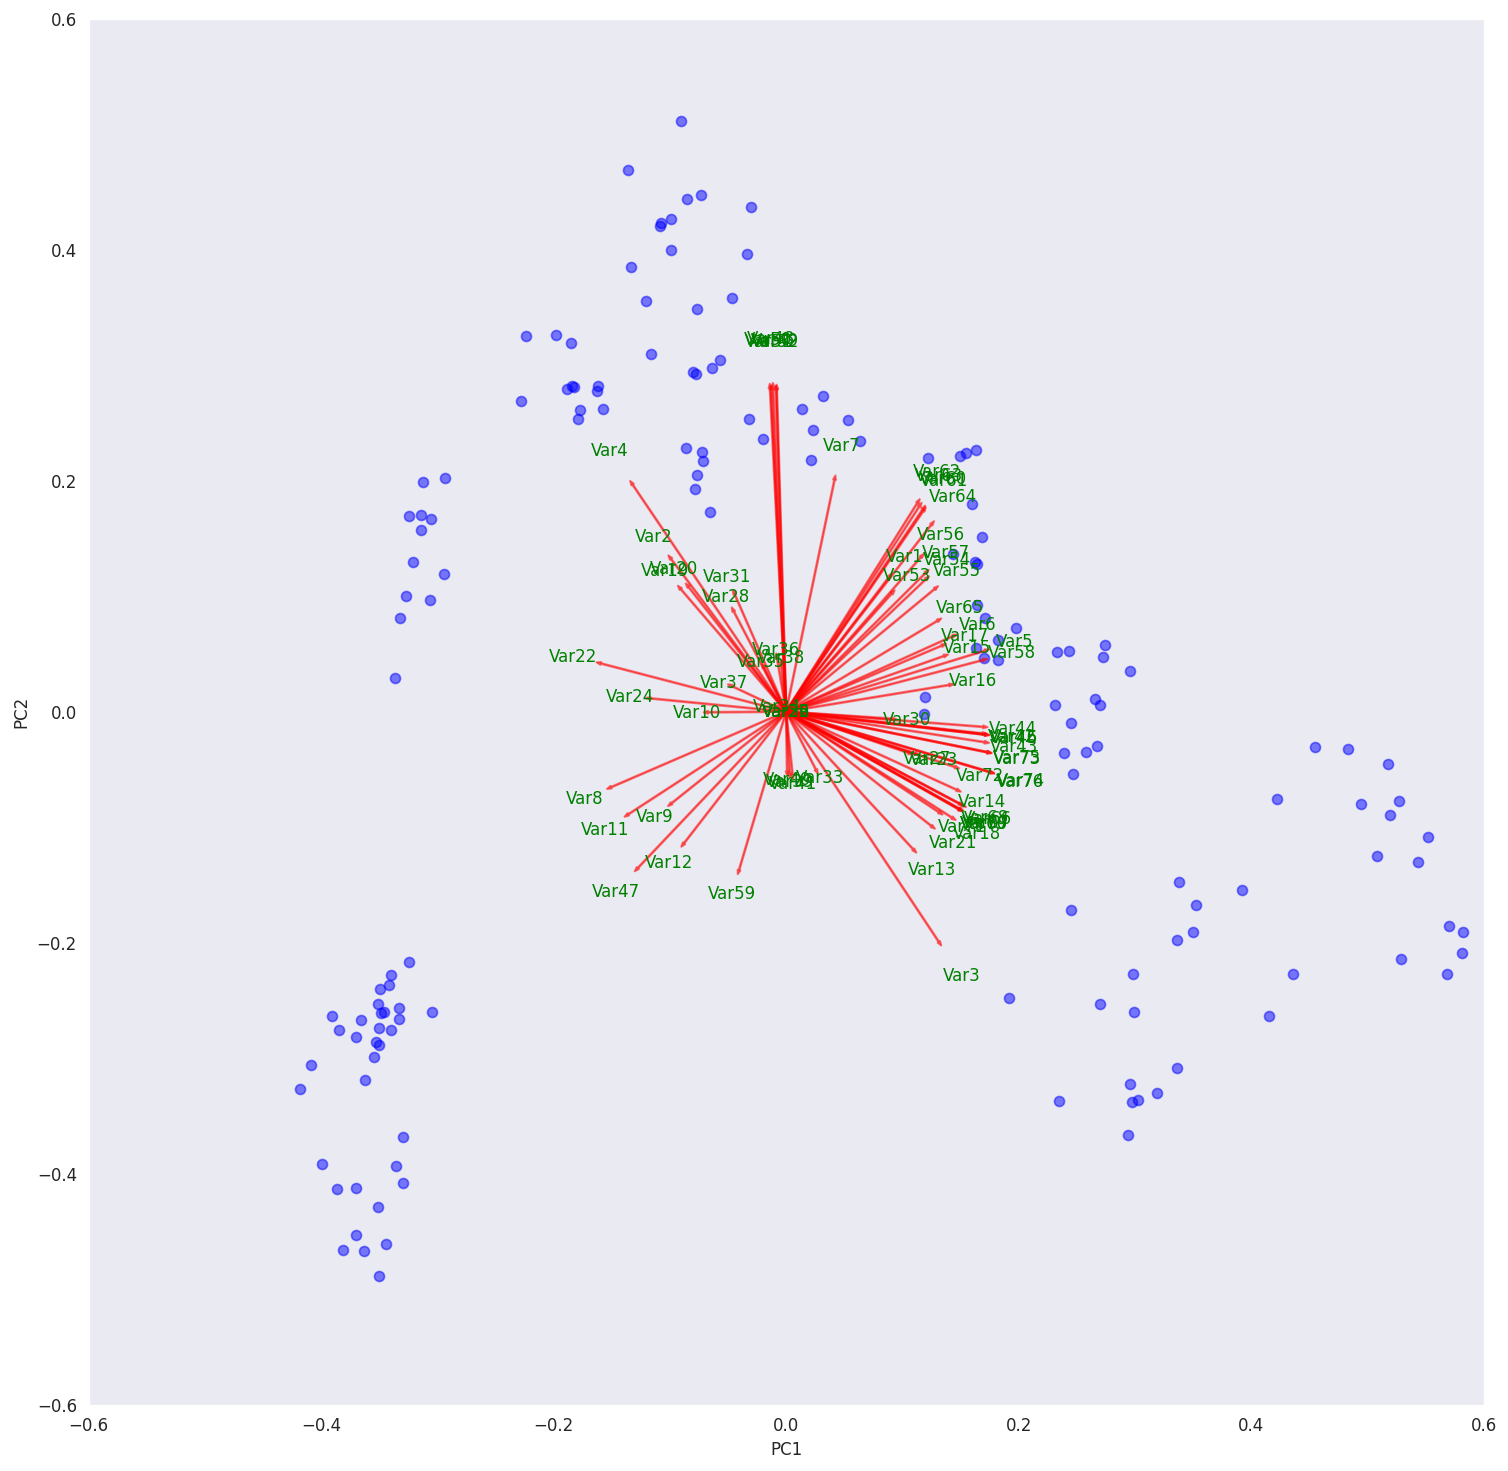

In [178]:
def myplot(score, coeff, labels=None):
    xs = score[:, 0]
    ys = score[:, 1]
    n = coeff.shape[0]
    scalex = 1.0 / (xs.max() - xs.min())
    scaley = 1.0 / (ys.max() - ys.min())
    plt.figure(figsize=(15, 15))
    plt.scatter(xs * scalex, ys * scaley, alpha=0.5, color='blue')  # Use a fixed color
    for i in range(n):
        plt.arrow(0, 0, coeff[i, 0], coeff[i, 1], color='r', alpha=0.5)
        if labels is None:
            plt.text(coeff[i, 0] * 1.15, coeff[i, 1] * 1.15, "Var" + str(i + 1), color='g', ha='center', va='center')
        else:
            plt.text(coeff[i, 0] * 1.15, coeff[i, 1] * 1.15, labels[i], color='g', ha='center', va='center')
    plt.xlim(-.6, .6)
    plt.ylim(-.6, .6)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid()

# Call the function with fixed color
myplot(X_pca, np.transpose(pca.components_[:2, :]))
plt.show()